<a href="https://colab.research.google.com/github/levina-ai/financial-tweet-sentiment/blob/main/01_model_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 01 — Model Benchmarking & Selection

This notebook contains the full experimentation pipeline for the financial tweet sentiment classification task.

The objective of this notebook is to:
- Perform exploratory data analysis (EDA)
- Design and compare multiple text preprocessing strategies
- Evaluate different feature representations (BOW, TF-IDF, Word2Vec, transformer embeddings)
- Fine-tune transformer models (RoBERTa and FinancialBERT)
- Benchmark classical machine learning models against transformer-based approaches

- Perform systematic hyperparameter tuning
- Select the final model based on macro-F1 performance

## Evaluation protocol
- Stratified train/validation split
- Stratified K-Fold cross-validation for hyperparameter tuning
- Macro-F1 as the primary metric (due to class imbalance)
- Accuracy, precision, and recall reported for completeness

## 0. Imports & Load data

In [ ]:
!pip install gensim

In [ ]:
# basics
import os, re, string, random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from itertools import chain
from collections import Counter

# data
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, auc, mean_squared_error, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# other ml
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBClassifier

# nlp
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from gensim.models import Word2Vec
nltk.download("punkt")
nltk.download("stopwords")
stopwords = set(stopwords.words("english"))
import spacy
nlp = spacy.load("en_core_web_sm")

# transformers
import torch
from datasets import Dataset
from transformers import AutoConfig, AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorWithPadding, pipeline

# utils
from tqdm.notebook import tqdm

# seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_df = pd.read_csv("train.csv")
test_df  = pd.read_csv("test.csv")

display(train_df.head())

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


In [ ]:
print(train_df.shape, test_df.shape)

(9543, 2) (2388, 2)


## 1. Data exploration


The column `label ` represents the sentiment,  each tweet can have
one of the following labels: Bearish (0), Bullish (1), or Neutral (2).

Our sample is isn't balance we have more 'Neutral' tweets.

In [ ]:
train_df["label"].value_counts(normalize=True)

,proportion
label,
2,0.647386
1,0.201509
0,0.151106


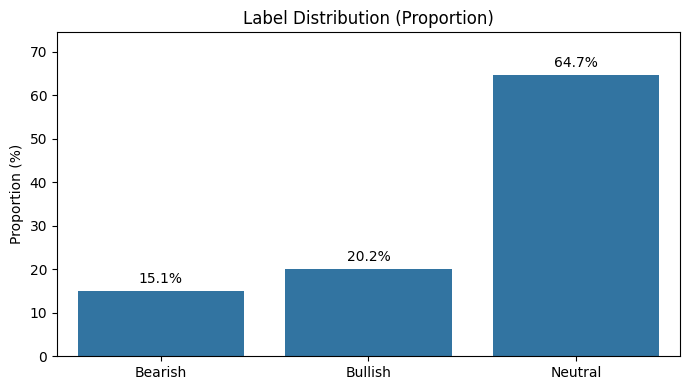

In [ ]:
# Proportion of each label
label_names = {0: "Bearish", 1: "Bullish", 2: "Neutral"}

prop = (train_df["label"]
        .value_counts(normalize=True)
        .reindex([0, 1, 2]) * 100)

plot_df = prop.rename_axis("label").reset_index(name="percent")
plot_df["label_name"] = plot_df["label"].map(label_names)

plt.figure(figsize=(7, 4))
ax = sns.barplot(data=plot_df, x="label_name", y="percent" )

ax.set_title("Label Distribution (Proportion)")
ax.set_xlabel("")
ax.set_ylabel("Proportion (%)")
ax.set_ylim(0, plot_df["percent"].max() * 1.15)

# add % labels on bars
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%",
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha="center", va="bottom", fontsize=10, xytext=(0, 3),
                textcoords="offset points")

plt.tight_layout()
plt.show()

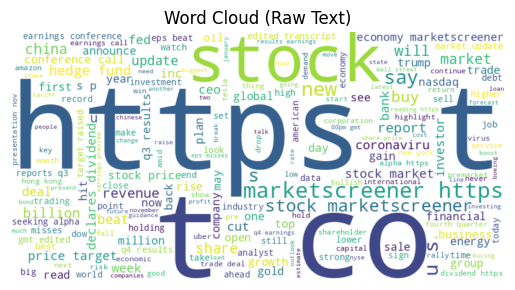

In [ ]:
raw_text = ' '.join(train_df['text'].fillna('')).lower()
raw_wc = WordCloud(width=800, height=400, background_color='white').generate(raw_text)
plt.imshow(raw_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (Raw Text)')
plt.show()

In [ ]:
all_words = ' '.join(train_df['text']).split()
freq = pd.Series(all_words).value_counts()
freq.sort_values(ascending=False)[0:10]

,count
to,2332
the,1820
of,1464
-,1390
in,1361
on,1136
for,1032
a,970
and,898
The,663


### Duplicates/Missing

In [ ]:
# check duplicates
train_df.duplicated().sum()

np.int64(0)

In [ ]:
# check missing values
train_df.isnull()

print(f'Number of missing values: {train_df.isnull().sum()}')

Number of missing values: text     0
label    0
dtype: int64


### Number of words by label

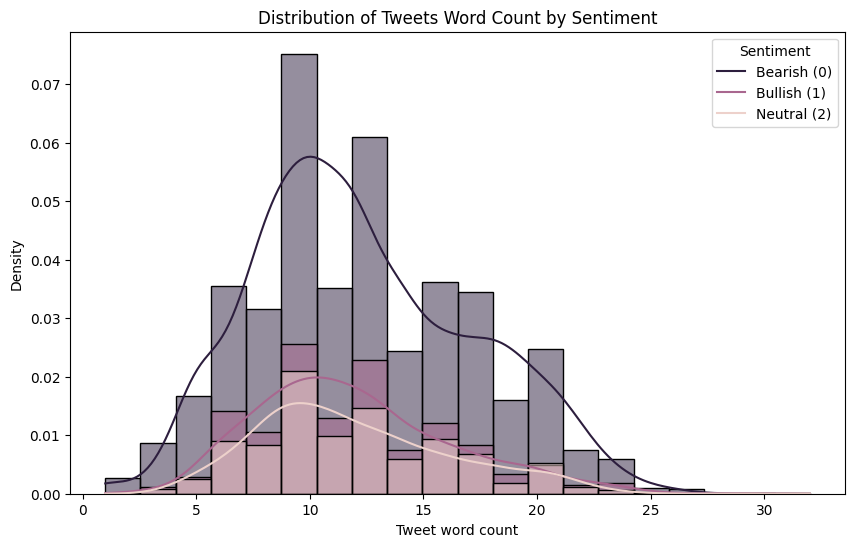

In [ ]:
# Plot the number of words by Label
train_df["word_count"] = train_df["text"].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(data= train_df, x = 'word_count', hue ='label', kde= True, bins=20, stat='density')
plt.title("Distribution of Tweets Word Count by Sentiment")
plt.xlabel("Tweet word count")
plt.ylabel("Density")
plt.legend(title="Sentiment", labels =['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.show()

### Length distribution by label

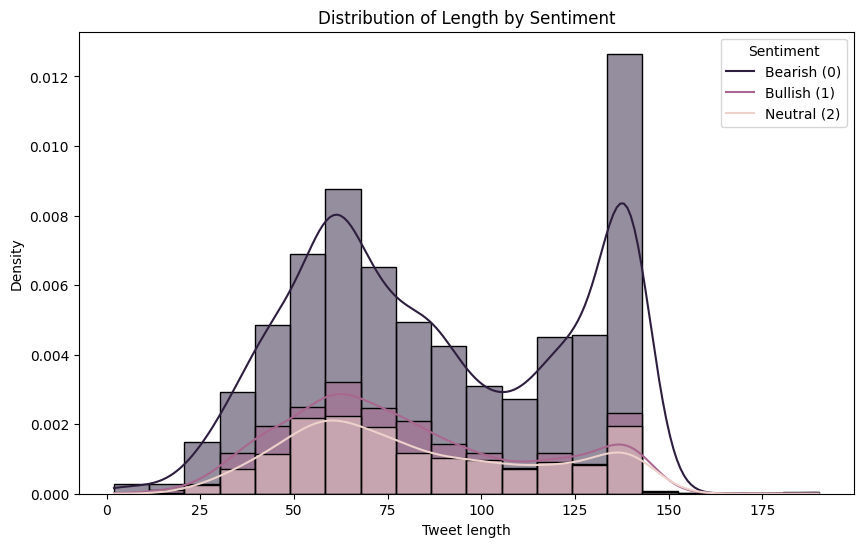

In [ ]:
# Plot the distribution of Label lengths

train_df['text_length'] = train_df['text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data= train_df, x = 'text_length', hue ='label', kde= True, bins=20, stat='density')
plt.title("Distribution of Length by Sentiment")
plt.xlabel("Tweet length")
plt.ylabel("Density")
plt.legend(title="Sentiment", labels =['Bearish (0)', 'Bullish (1)', 'Neutral (2)'])
plt.show()


All three sentiment distributions overlap heavily across most tweet lengths.
All sentiments show a right-skewed shape.
- Many short-to-medium tweets.
- Fewer very long tweets.

Indicating that tweet length alone is not a strong discriminator of sentiment.

### Most frequent words by label

In [ ]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)                      # remove URLs
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # punctuation -> space
    text = re.sub(r"\s+", " ", text).strip()

    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in stopwords and w.isalpha()]  # keep only words
    return tokens

train_df["clean_text"] = train_df["text"].apply(clean_text)

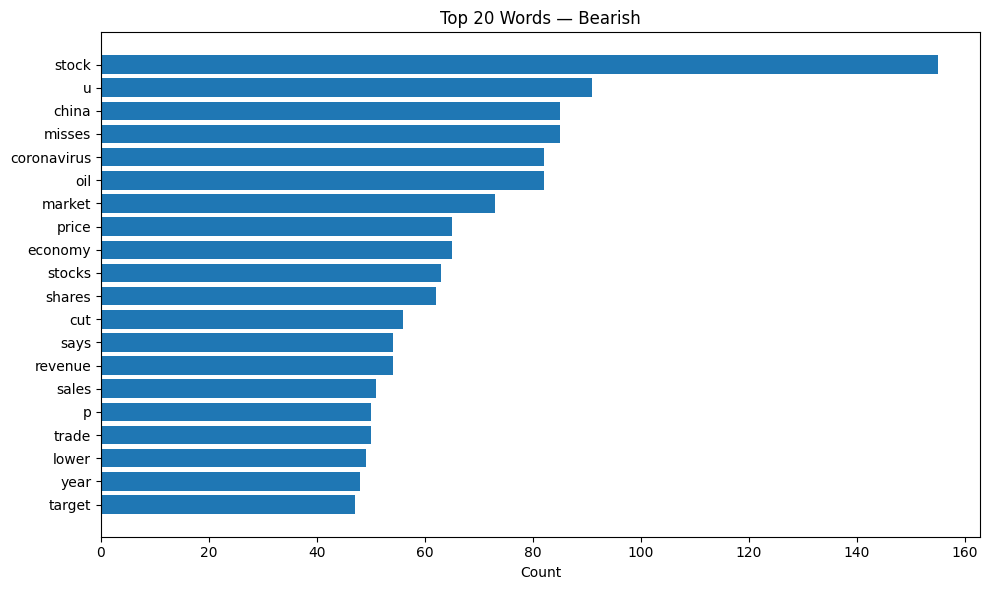

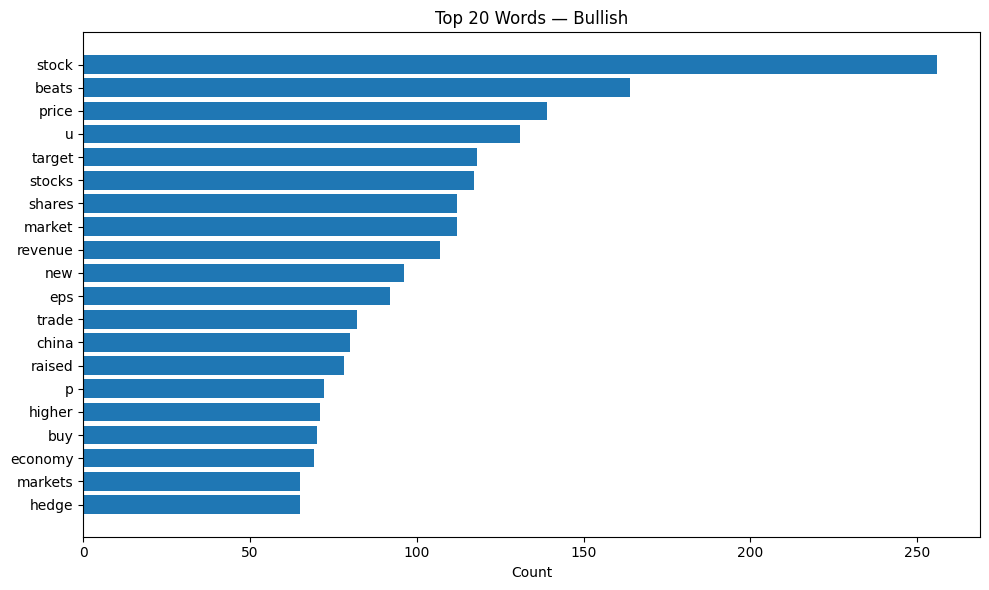

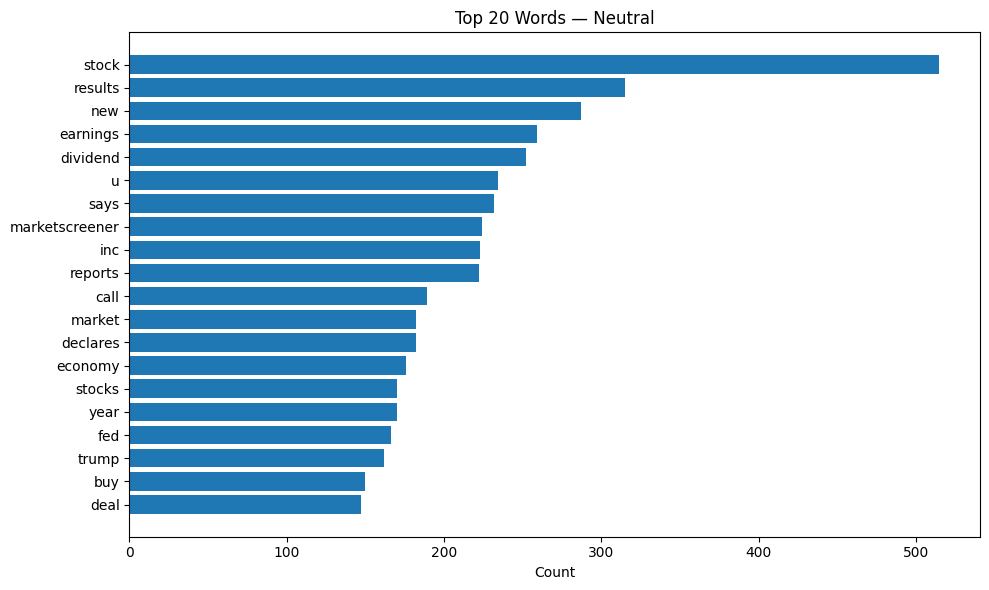

In [ ]:
top_n = 20
label_names = {0: "Bearish", 1: "Bullish", 2: "Neutral"}

for label in sorted(train_df["label"].unique()):
    tokens = chain.from_iterable(train_df.loc[train_df["label"] == label, "clean_text"])
    most_common = Counter(tokens).most_common(top_n)

    words = [w for w, c in most_common]
    counts = [c for w, c in most_common]

    plt.figure(figsize=(10, 6))
    plt.barh(words[::-1], counts[::-1])
    plt.title(f"Top {top_n} Words — {label_names.get(label, label)}")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

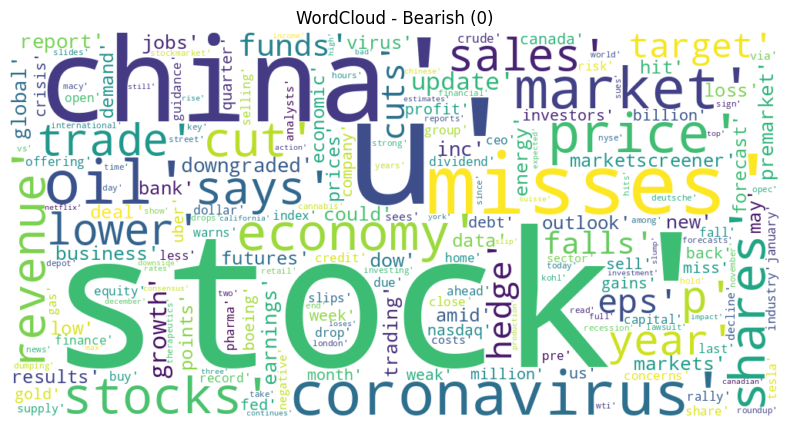

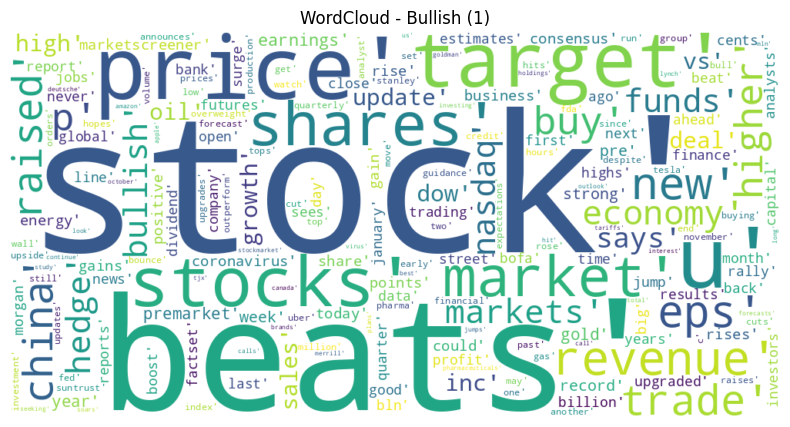

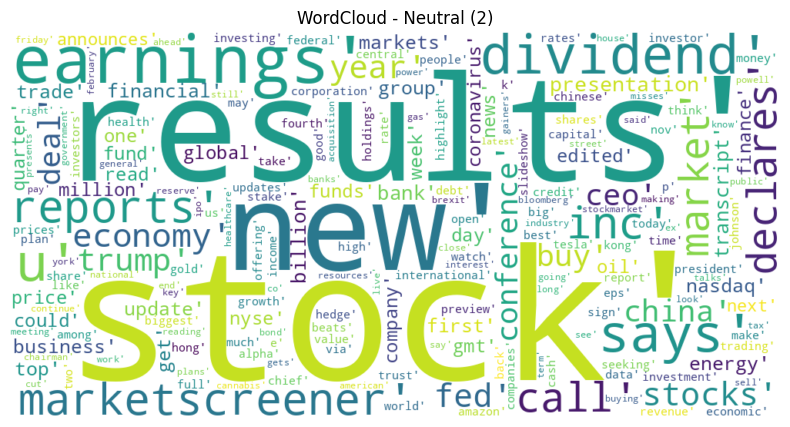

In [ ]:
sentiment_names = {0: "Bearish (0)", 1: "Bullish (1)", 2: "Neutral (2)"}

for lab in [0, 1, 2]:
    text_blob = " ".join(train_df.loc[train_df["label"] == lab, "clean_text"].astype(str))

    wc = WordCloud(
        width=1000,
        height=500,
        background_color="white",
        stopwords=stopwords,
        collocations=False  # helps avoid bigrams like "new_york"
    ).generate(text_blob)

    plt.figure(figsize=(12, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud - {sentiment_names[lab]}")
    plt.show()

In [ ]:
# Check if stop_words remove negation words
text = "I do not like this and I can't recommend it."
tokens = [t.lower() for t in word_tokenize(text)]
kept = [t for t in tokens if t not in stopwords]
removed = [t for t in tokens if t in stopwords]
kept, removed

(['like', 'ca', "n't", 'recommend', '.'],
 ['i', 'do', 'not', 'this', 'and', 'i', 'it'])

Removing negation words with stopwords is a concern. In the preprocessing, this is adressed.

# Split Data ➗

In [ ]:
# Data split that preserves Dataset proportions
X = train_df["text"]
y = train_df["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

In [ ]:
print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Label distribution in train set: {y_train.value_counts()}')
print(f'Label distribution in validation set: {y_val.value_counts()}')

Train set size: 7634
Validation set size: 1909
Label distribution in train set: label
2    4942
1    1538
0    1154
Name: count, dtype: int64
Label distribution in validation set: label
2    1236
1     385
0     288
Name: count, dtype: int64


# Helper

In [ ]:
LABELS = [0,1,2]
LABEL_NAMES = ["Bearish","Bullish","Neutral"]

def evaluate_multiclass(y_true, y_pred, title=""):
    print(title)
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Macro-F1 :", round(f1_score(y_true, y_pred, average="macro"), 4))
    print(classification_report(y_true, y_pred, target_names=LABEL_NAMES, digits=3))
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    ConfusionMatrixDisplay(cm, display_labels=LABEL_NAMES).plot(cmap="Blues")
    plt.title(title if title else "Confusion Matrix")
    plt.show()

In [ ]:
def add_to_leaderboard(name, y_true, y_pred, lb_type):
    lb_type.append({
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
    })


# Text Preprocessing 📊


In [ ]:
# Keep negations (important for sentiment)
NEGATIONS = {"not", "no", "never", "n't"}

def base_clean(text: str) -> str:
    """
    Base cleaning shared by all feature types.
    - lowercase
    - remove URLs
    - remove RT
    - remove @mentions
    - remove leading '#', keep hashtag word
    - normalize whitespace
    NOTE: does NOT remove punctuation.
    """
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)   # URLs
    text = re.sub(r"\brt\b", " ", text)    # RT
    text = re.sub(r"@\w+", " ", text)      # @ mentions
    text = re.sub(r"#", "", text)          # keep hashtag words
    text = re.sub(r"\s+", " ", text).strip()
    return text

## Word2vec preprocessor



In [ ]:
def w2v_tokenize(text: str) -> List[str]:
    """
    Tokenizer for gensim Word2Vec with:
    - base cleaning
    - regex cleaning (apostrophes, cashtags, punctuation removal)
    - stopword removal (but keeps negations)
    - lemmatization (misses -> miss)
    """
    text = base_clean(text)

    # Normalize curly apostrophes + don’t -> dont)
    text = re.sub(r"’", "'", text)
    text = re.sub(r"'", "", text)

    # Convert $tsla -> cashtag_tsla
    text = re.sub(r"\$([a-z]{1,10})", r" cashtag_\1 ", text)

    # Remove punctuation
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)

    tokens = text.split()

    # Remove stopwords, but keep negations
    sw = stopwords - NEGATIONS
    tokens = [t for t in tokens if t not in sw]

    # remove meaningless 1-letter tokens
    tokens = [t for t in tokens if len(t) > 1 or t in NEGATIONS]

    # Lemmatize (keep negations and cashtags as-is)
    doc = nlp(" ".join(tokens))
    tokens = [
        t.text if (t.text in NEGATIONS or t.text.startswith("cashtag_")) else t.lemma_
        for t in doc
        if not t.is_space
    ]

    return tokens


## BOW preprocessor

In [ ]:
def bow_preprocessor(text: str) -> str:
    """
    Preprocessor for CountVectorizer with:
    - base cleaning
    - regex cleaning (normalize apostrophes, remove punctuation)
    - stopword removal (but keeps negations)
    - lemmatization (misses -> miss)
    """
    text = base_clean(text)

    # Normalize curly apostrophes + don't-> dont
    text = text.replace("’", "'")
    text = text.replace("'", "")

    # Remove punctuation
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)

    text = re.sub(r"\s+", " ", text).strip()

    tokens = text.split()

    # Remove stopwords, but keep negations
    sw = stopwords - NEGATIONS
    tokens = [t for t in tokens if t not in sw]

    # remove meaningless 1-letter tokens
    tokens = [t for t in tokens if len(t) > 1 or t in NEGATIONS]

    # Lemmatize (keep negations as-is)
    doc = nlp(" ".join(tokens))
    tokens = [
        t.text if t.text in NEGATIONS else t.lemma_
        for t in doc
        if not t.is_space
    ]

    return " ".join(tokens)


## TF-IDF preprocessor

In [ ]:
def tfidf_preprocessor(text: str) -> str:
    """
    Preprocessor for TfidfVectorizer with lemmatization.
    - uses base_clean
    - removes punctuation but keeps apostrophes (don't, I'm)
    - no stopword removal (TF-IDF down-weights common words)
    - lemmatization (misses -> miss)
    """
    text = base_clean(text)

    # remove punctuation except apostrophe
    punct = string.punctuation.replace("'", "")
    text = re.sub(rf"[{re.escape(punct)}]", " ", text)

    # collapse whitespace
    text = re.sub(r"\s+", " ", text).strip()

    # lemmatize (keep contractions / apostrophes as they are in the text)
    doc = nlp(text)
    lemmas = [t.lemma_ for t in doc if not t.is_space]

    return " ".join(lemmas)


## Transformer preprocessor

In [ ]:
def transformer_preprocessor(text: str) -> str:
    """
    Preprocessor for transformer encoders.
    Minimal cleaning only: keep punctuation and stopwords.
    - uses base_clean
    - does NOT strip punctuation (tranformer are train on it)
    """
    text = base_clean(text)
    return text

# Feature enginering

### Word2vec

In [ ]:
# X_train / X_val are raw texts (pd.Series)
tokenized_train = [w2v_tokenize(t) for t in X_train]
tokenized_val   = [w2v_tokenize(t) for t in X_val]

In [ ]:
# check how negations look like
i = X_train[X_train.str.lower().str.contains("don't")].index[1]
print(X_train.loc[i])
print(w2v_tokenize(X_train.loc[i]))

Allstate CEO: Driving is way down due to coronavirus and 'we don't know' if trend will last https://t.co/7DK6AgJi9K
['allstate', 'ceo', 'driving', 'way', 'due', 'coronavirus', 'do', 'not', 'know', 'trend', 'last']


In [ ]:
i = X_train[X_train.str.lower().str.contains("n't")].index[0]
print(X_train.loc[i])
print(w2v_tokenize(X_train.loc[i]))

China won't have to sacrifice economic growth or prosperity to go carbon neutral in the next few decades, according… https://t.co/Nq9sSVHtgq
['china', 'will', 'not', 'sacrifice', 'economic', 'growth', 'prosperity', 'go', 'carbon', 'neutral', 'next', 'decade', 'accord', '…']


The preprocessing method was successful at keeping negations, as 'don't', 'won't' -> 'do not', 'will not'

In [ ]:
w2v_model = Word2Vec(
    sentences=tokenized_train,
    vector_size=200,
    window=5,
    min_count=2,
    sg=1,
    workers=4,
    seed=SEED
)

w2v_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1, sg=1)

In [ ]:
def tweet_to_vec(tokens, model):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    if not vecs:
        return np.zeros(model.vector_size, dtype=float)
    return np.mean(vecs, axis=0)

X_train_w2v = np.vstack([tweet_to_vec(toks, w2v_model) for toks in tokenized_train])
X_val_w2v   = np.vstack([tweet_to_vec(toks, w2v_model) for toks in tokenized_val])

print(X_train_w2v.shape, X_val_w2v.shape)

(7634, 100) (1909, 100)


### TF-ID

In [ ]:
pipeline_tfid= TfidfVectorizer(
        preprocessor=tfidf_preprocessor,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9)

### BOW

In [ ]:
pipeline_bow= CountVectorizer(
        preprocessor=tfidf_preprocessor,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.9)

## Transformer encoder

In [ ]:
# Minimal cleaning for transformers
X_train_tx = X_train.apply(transformer_preprocessor)
X_val_tx   = X_val.apply(transformer_preprocessor)

In [ ]:
# Check whether max_length=96 covers most tweet lengths
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

lens = [len(ids) for ids in tokenizer(
    X_train_tx.tolist(),
    add_special_tokens=True,
    truncation=False,
    padding=False
)["input_ids"]]

lens = np.array(lens)

print(f"% tweets <= 96 tokens: {(lens <= 64).mean() * 100:.2f}%")

% tweets <= 96 tokens: 99.96%


In [ ]:
# Encode tweets into embeddings using a transformer encoder.
# Allowsfor CLS pooling and mean pooling
# Truncates/pads to max_length=96.
@torch.inference_mode()
def encode_texts(texts, batch_size=16, max_length=96, pooling="cls", show_progress=True):
    texts = texts.tolist() if hasattr(texts, "tolist") else list(texts)

    n = len(texts)
    n_batches = (n + batch_size - 1) // batch_size

    all_vecs = []
    it = range(0, n, batch_size)
    if show_progress:
        it = tqdm(it, total=n_batches, desc="Encoding", unit="batch")

    for i in it:
        batch = texts[i:i+batch_size]

        enc = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )

        # move inputs to same device as model
        enc = {k: v.to(device) for k, v in enc.items()}

        out = encoder(**enc)
        last = out.last_hidden_state  # (B, T, H)

        if pooling == "cls":
            vecs = last[:, 0, :]
        elif pooling == "mean":
            mask = enc["attention_mask"].unsqueeze(-1).to(last.dtype)  # float mask
            vecs = (last * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)

        all_vecs.append(vecs.detach().float().cpu().numpy())  # float() -> stable numpy

    return np.vstack(all_vecs)


### FinBERT

In [ ]:
# Check if labels compatible
model_name = "ProsusAI/finbert"
cfg = AutoConfig.from_pretrained(model_name)

print("num_labels:", cfg.num_labels)
print("id2label:", cfg.id2label)
print("label2id:", cfg.label2id)

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

num_labels: 3
id2label: {0: 'positive', 1: 'negative', 2: 'neutral'}
label2id: {'positive': 0, 'negative': 1, 'neutral': 2}


Model labels differ from the labels in our dataset. This is addressed when employing the transformer encoder as a classification method as well as for the fine-tuning of the models.

In [ ]:
MODEL_NAME = "ProsusAI/finbert"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encoder = AutoModel.from_pretrained(MODEL_NAME).eval()

# Pick GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)

# Use half precision (float16) since it's allowed on GPU
# to speed up inference and reduce memory
use_fp16 = (device.type == "cuda")
if use_fp16:
    encoder.half()

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
X_train_emb_finbert = encode_texts(X_train_tx, pooling="mean")
X_val_emb_finbert   = encode_texts(X_val_tx, pooling="mean")

X_train_emb_finbert.shape, X_val_emb_finbert.shape

Encoding:   0%|          | 0/478 [00:00<?, ?batch/s]

Encoding:   0%|          | 0/120 [00:00<?, ?batch/s]

((7634, 768), (1909, 768))

In [ ]:
# save
X_train_emb_finbert = np.asarray(X_train_emb_finbert, dtype=np.float32)
X_val_emb_finbert   = np.asarray(X_val_emb_finbert, dtype=np.float32)

np.save("X_train_emb_finbert.npy", X_train_emb_finbert)
np.save("X_val_emb_finbert.npy",   X_val_emb_finbert)

In [ ]:
'''X_train_emb_fimbert = pd.read_csv('X_train_emb_finbert.csv')
X_val_emb_finbert = pd.read_csv('X_val_emb_finbert.csv')'''

### RoBERTA

In [ ]:
# Check if labels are compatible
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
cfg = AutoConfig.from_pretrained(MODEL_NAME)

print("num_labels:", cfg.num_labels)
print("id2label:", cfg.id2label)
print("label2id:", cfg.label2id)

num_labels: 3
id2label: {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id: {'negative': 0, 'neutral': 1, 'positive': 2}


In [ ]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encoder = AutoModel.from_pretrained(MODEL_NAME).eval()

encoder.to(device)
if use_fp16:
    encoder.half()

X_train_emb_roberta = encode_texts(X_train_tx, pooling="mean")
X_val_emb_roberta  = encode_texts(X_val_tx, pooling="mean")

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Encoding:   0%|          | 0/478 [00:00<?, ?batch/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Encoding:   0%|          | 0/120 [00:00<?, ?batch/s]

In [ ]:
# save
X_train_emb_roberta = np.asarray(X_train_emb_roberta, dtype=np.float32)
X_val_emb_roberta  = np.asarray(X_val_emb_roberta, dtype=np.float32)

np.save("X_train_emb_roberta.npy", X_train_emb_roberta)
np.save("X_val_emb_roberta.npy",   X_val_emb_roberta)

### EXTRA: Fined-tuned RoBERTa

In [ ]:
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"

# 1) Load base model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# model mapping {"negative": 0, "neutral": 1, "positive": 2}
label2id = model.config.label2id
id2label = model.config.id2label

# 2) dataset label ids: 0=negative, 1=positive, 2=neutral
DATA_ID2LABEL = {0: "negative", 1: "positive", 2: "neutral"}

# Map dataset ids -> model ids
y_train_m = [label2id[DATA_ID2LABEL[int(y)]] for y in y_train]
y_val_m   = [label2id[DATA_ID2LABEL[int(y)]] for y in y_val]

# 3) Build HF datasets (labels must be a plain Python list of ints)
train_ds = Dataset.from_dict({"text": X_train_tx.tolist(), "label": y_train_m})
val_ds   = Dataset.from_dict({"text": X_val_tx.tolist(),   "label": y_val_m})

# 4) Tokenize + dynamic padding
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=96)

train_ds = train_ds.map(tok, batched=True)
val_ds   = val_ds.map(tok, batched=True)

collator = DataCollatorWithPadding(tokenizer)

# 5) Metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1_macro": f1_score(p.label_ids, preds, average="macro"),
    }

args = TrainingArguments(
    output_dir="twroberta_ft",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none",
    dataloader_pin_memory=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.480100,0.347793,0.881090,0.849264


TrainOutput(global_step=955, training_loss=0.4376470116420566, metrics={'train_runtime': 35.4895, 'train_samples_per_second': 215.106, 'train_steps_per_second': 26.909, 'total_flos': 120116414126772.0, 'train_loss': 0.4376470116420566, 'epoch': 1.0})

In [ ]:
SAVE_DIR = "finetuned_roberta"
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

('finetuned_roberta/tokenizer_config.json',
 'finetuned_roberta/special_tokens_map.json',
 'finetuned_roberta/vocab.json',
 'finetuned_roberta/merges.txt',
 'finetuned_roberta/added_tokens.json',
 'finetuned_roberta/tokenizer.json')

In [ ]:
# Get model embeddings
MODEL_NAME = "finetuned_roberta"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
encoder = AutoModel.from_pretrained(MODEL_NAME).eval()

encoder.to(device)
if use_fp16:
    encoder.half()

X_train_emb_finetuned= encode_texts(X_train_tx, pooling="mean")
X_val_emb_finetuned   = encode_texts(X_val_tx, pooling="mean")

Some weights of RobertaModel were not initialized from the model checkpoint at finetuned_roberta and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Encoding:   0%|          | 0/478 [00:00<?, ?batch/s]

Encoding:   0%|          | 0/120 [00:00<?, ?batch/s]

In [ ]:
# save for later
X_train_emb_finetuned = np.asarray(X_train_emb_finetuned, dtype=np.float32)
X_val_emb_finetuned   = np.asarray(X_val_emb_finetuned, dtype=np.float32)

np.save("X_train_emb_finetuned.npy", X_train_emb_finetuned)
np.save("X_val_emb_finetuned.npy",   X_val_emb_finetuned)

###  EXTRA: Fined-tuned FinantialBERT

In [ ]:
# Check if labels are compatible
MODEL_NAME = "ahmedrachid/FinancialBERT-Sentiment-Analysis"
cfg = AutoConfig.from_pretrained(MODEL_NAME)

print("num_labels:", cfg.num_labels)
print("id2label:", cfg.id2label)
print("label2id:", cfg.label2id)

config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

num_labels: 3
id2label: {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id: {'negative': 0, 'neutral': 1, 'positive': 2}


In [ ]:
MODEL_NAME = "ahmedrachid/FinancialBERT-Sentiment-Analysis"

# 1) Load base model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Model mapping
label2id = model.config.label2id
id2label = model.config.id2label

# 2) dataset label ids: 0=negative, 1=positive, 2=neutral
DATA_ID2LABEL = {0: "negative", 1: "positive", 2: "neutral"}

# Map dataset ids -> model ids
y_train_m = [label2id[DATA_ID2LABEL[int(y)]] for y in y_train]
y_val_m   = [label2id[DATA_ID2LABEL[int(y)]] for y in y_val]

# 3) Build HF datasets
train_ds = Dataset.from_dict({"text": X_train_tx.tolist(), "label": y_train_m})
val_ds   = Dataset.from_dict({"text": X_val_tx.tolist(),   "label": y_val_m})

# 4) Tokenize + dynamic padding
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tok(batch):
    return tokenizer(batch["text"], truncation=True, max_length=96)

train_ds = train_ds.map(tok, batched=True)
val_ds   = val_ds.map(tok, batched=True)

collator = DataCollatorWithPadding(tokenizer)

# 5) Metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    return {
        "accuracy": accuracy_score(p.label_ids, preds),
        "f1_macro": f1_score(p.label_ids, preds, average="macro"),
    }

args = TrainingArguments(
    output_dir="twroberta_ft",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    report_to="none",
    dataloader_pin_memory=False,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collator,
    compute_metrics=compute_metrics,
)

trainer.train()

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/7634 [00:00<?, ? examples/s]

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.515600,0.368655,0.861184,0.814885


TrainOutput(global_step=955, training_loss=0.4677464829689545, metrics={'train_runtime': 36.6807, 'train_samples_per_second': 208.12, 'train_steps_per_second': 26.035, 'total_flos': 116666133879456.0, 'train_loss': 0.4677464829689545, 'epoch': 1.0})

In [ ]:
SAVE_DIR = "finetuned_financialBERT"
trainer.save_model(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

('finetuned_financialBERT/tokenizer_config.json',
 'finetuned_financialBERT/special_tokens_map.json',
 'finetuned_financialBERT/vocab.txt',
 'finetuned_financialBERT/added_tokens.json',
 'finetuned_financialBERT/tokenizer.json')

# Classifier 🔍

## Transformer Encoders

In [ ]:
# Transformer-based model configs
transformer_models = {
    "FinancialBERT": "ahmedrachid/FinancialBERT-Sentiment-Analysis",
    "FinBERT": "ProsusAI/finbert",
    "RoBERTa (Twitter)": "cardiffnlp/twitter-roberta-base-sentiment-latest",
    "Fined-tuned RoBERTa": "finetuned_roberta",
    "Fined-tuned FinancialBERT": "finetuned_financialBERT"
}

In [ ]:
# Function to map correctly classifiers labels
# Since labels don't match
def map_model_label_to_012(model_name: str, label: str) -> int:
    """
    Map a model's output label string into our dataset label space: 0/1/2.
    """
    lab = label.lower()

    if "positive" in lab:
        return 1
    if "negative" in lab:
        return 0
    if "neutral" in lab:
        return 2

    return 2  # default neutral


🔬 Running Transformer-based Sentiment Models

🔍 Model: FinancialBERT
------------------------------------------------------------


Device set to use cuda:0


Inference with FinancialBERT:   0%|          | 0/1909 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


FinancialBERT
Accuracy: 0.7365
Macro-F1 : 0.6751
              precision    recall  f1-score   support

     Bearish      0.584     0.566     0.575       288
     Bullish      0.605     0.691     0.645       385
     Neutral      0.821     0.790     0.805      1236

    accuracy                          0.737      1909
   macro avg      0.670     0.682     0.675      1909
weighted avg      0.742     0.737     0.738      1909



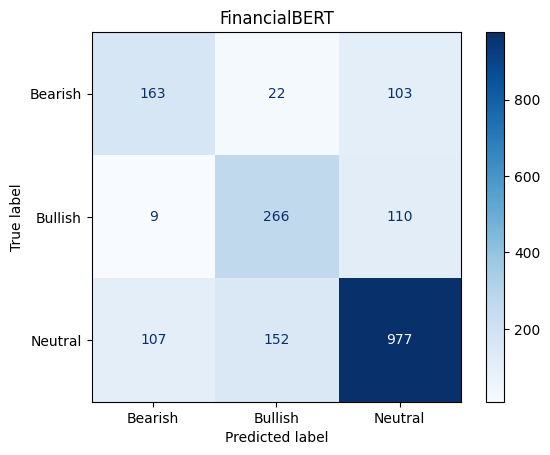

🔍 Model: FinBERT
------------------------------------------------------------


Device set to use cuda:0


Inference with FinBERT:   0%|          | 0/1909 [00:00<?, ?it/s]

FinBERT
Accuracy: 0.6998
Macro-F1 : 0.6526
              precision    recall  f1-score   support

     Bearish      0.462     0.764     0.576       288
     Bullish      0.587     0.629     0.607       385
     Neutral      0.856     0.707     0.774      1236

    accuracy                          0.700      1909
   macro avg      0.635     0.700     0.653      1909
weighted avg      0.742     0.700     0.711      1909



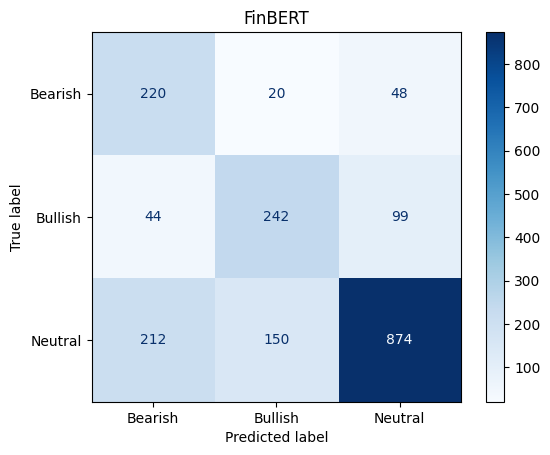

🔍 Model: RoBERTa (Twitter)
------------------------------------------------------------


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


Inference with RoBERTa (Twitter):   0%|          | 0/1909 [00:00<?, ?it/s]

RoBERTa (Twitter)
Accuracy: 0.67
Macro-F1 : 0.5762
              precision    recall  f1-score   support

     Bearish      0.485     0.500     0.492       288
     Bullish      0.587     0.403     0.478       385
     Neutral      0.727     0.793     0.759      1236

    accuracy                          0.670      1909
   macro avg      0.600     0.565     0.576      1909
weighted avg      0.662     0.670     0.662      1909



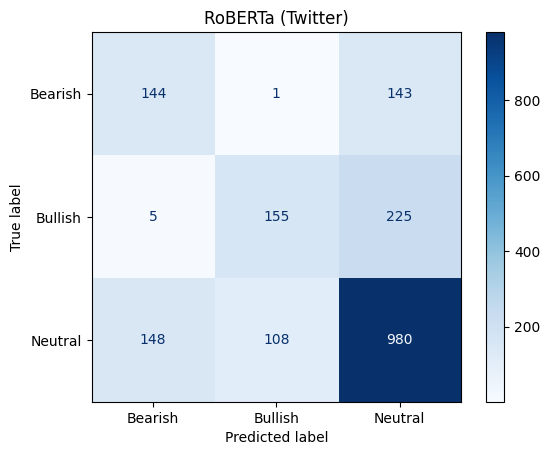

🔍 Model: Fined-tuned RoBERTa
------------------------------------------------------------


Device set to use cuda:0


Inference with Fined-tuned RoBERTa:   0%|          | 0/1909 [00:00<?, ?it/s]

Fined-tuned RoBERTa
Accuracy: 0.8811
Macro-F1 : 0.8493
              precision    recall  f1-score   support

     Bearish      0.799     0.799     0.799       288
     Bullish      0.868     0.805     0.836       385
     Neutral      0.903     0.924     0.914      1236

    accuracy                          0.881      1909
   macro avg      0.857     0.843     0.849      1909
weighted avg      0.881     0.881     0.881      1909



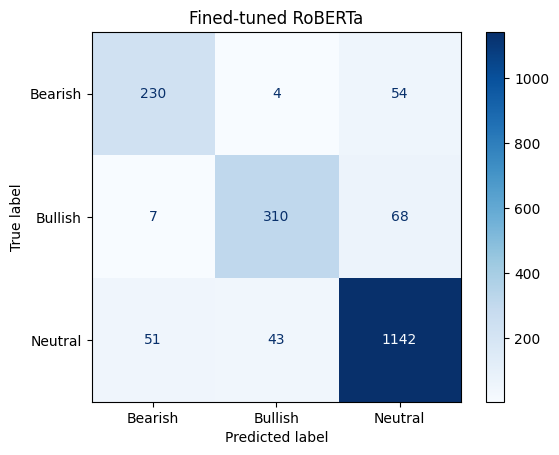

🔍 Model: Fined-tuned FinancialBERT
------------------------------------------------------------


Device set to use cuda:0


Inference with Fined-tuned FinancialBERT:   0%|          | 0/1909 [00:00<?, ?it/s]

Fined-tuned FinancialBERT
Accuracy: 0.8612
Macro-F1 : 0.8149
              precision    recall  f1-score   support

     Bearish      0.772     0.719     0.745       288
     Bullish      0.832     0.758     0.793       385
     Neutral      0.888     0.926     0.907      1236

    accuracy                          0.861      1909
   macro avg      0.831     0.801     0.815      1909
weighted avg      0.859     0.861     0.859      1909



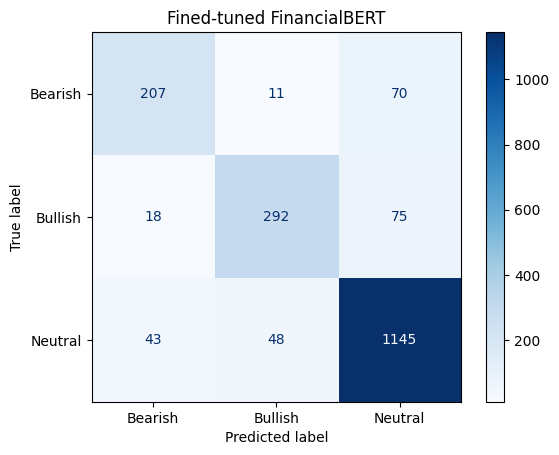

In [ ]:
leaderboard_transformer = []
model_predictions = {}

texts = X_val_tx.tolist() #basic clean X_val
true_labels = y_val.tolist()

print("\n🔬 Running Transformer-based Sentiment Models\n")

for model_desc, model_name in transformer_models.items():
    print(f"🔍 Model: {model_desc}")
    print("-" * 60)

    tok = AutoTokenizer.from_pretrained(model_name)
    mdl = AutoModelForSequenceClassification.from_pretrained(model_name)

    clf_pipe = pipeline(
        task="text-classification",
        model=mdl,
        tokenizer=tok,
        device=0 if torch.cuda.is_available() else -1,
        truncation=True,
        max_length=96
    )

    preds = []
    for text in tqdm(texts, desc=f"Inference with {model_desc}"):
        out = clf_pipe(text)[0]              # {'label': '...', 'score': ...}
        pred_012 = map_model_label_to_012(model_name, out["label"])
        preds.append(pred_012)

    model_predictions[model_desc] = preds

    add_to_leaderboard(model_desc, true_labels, preds, leaderboard_transformer)


    evaluate_multiclass(true_labels, preds, title=model_desc)

In [ ]:
leaderboard_transformer_df = pd.DataFrame(leaderboard_transformer).sort_values("f1_macro", ascending=False).reset_index(drop=True)
leaderboard_transformer_df.to_pickle("leaderboard_transformer.pkl")
leaderboard_transformer_df

,model,accuracy,precision_macro,recall_macro,f1_macro
0,Fined-tuned RoBERTa,0.881090,0.856813,0.842585,0.849264
1,Fined-tuned FinancialBERT,0.861184,0.830631,0.801189,0.814885
2,FinancialBERT,0.736511,0.669928,0.682445,0.675082
3,FinBERT,0.699843,0.635196,0.699860,0.652558
4,RoBERTa (Twitter),0.669984,0.599658,0.565159,0.576160


## Logit regression

In [ ]:
leaderboard_logit = []

### Word2vec

Word2vec + Logistic Regression
Accuracy: 0.5642
Macro-F1 : 0.4728
              precision    recall  f1-score   support

     Bearish      0.219     0.319     0.260       288
     Bullish      0.397     0.525     0.452       385
     Neutral      0.799     0.633     0.707      1236

    accuracy                          0.564      1909
   macro avg      0.472     0.493     0.473      1909
weighted avg      0.630     0.564     0.588      1909



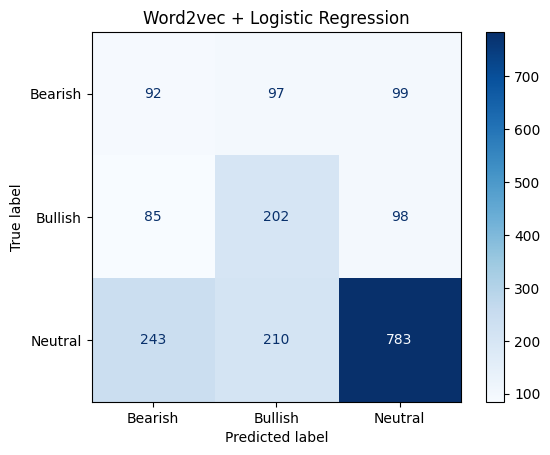

In [ ]:
clr = LogisticRegression(class_weight='balanced', random_state=SEED)
clr.fit(X_train_w2v, y_train)

y_pred_w2v = clr.predict(X_val_w2v)
evaluate_multiclass(y_val, y_pred_w2v, "Word2vec + Logistic Regression")
add_to_leaderboard("Word2vec + Logistic Regression", y_val, y_pred_w2v, leaderboard_logit)

### TD-IF

TF-IDF + Logistic Regression
Accuracy: 0.8114
Macro-F1 : 0.7491
              precision    recall  f1-score   support

     Bearish      0.640     0.674     0.657       288
     Bullish      0.699     0.719     0.709       385
     Neutral      0.891     0.872     0.881      1236

    accuracy                          0.811      1909
   macro avg      0.744     0.755     0.749      1909
weighted avg      0.814     0.811     0.813      1909



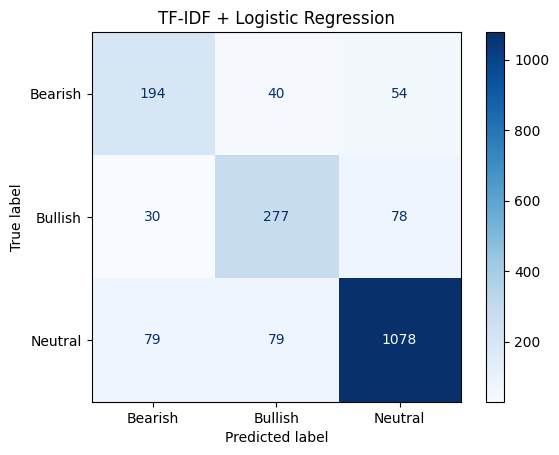

In [ ]:
pipe_tfidf_logit = Pipeline([
    ("tfidf", pipeline_tfid),
    ("clf", LogisticRegression(class_weight="balanced", random_state=SEED))
])

pipe_tfidf_logit.fit(X_train, y_train)

y_pred_tfidf = pipe_tfidf_logit.predict(X_val)
evaluate_multiclass(y_val, y_pred_tfidf, "TF-IDF + Logistic Regression")
add_to_leaderboard("TF-IDF + Logistic Regression", y_val, y_pred_tfidf, leaderboard_logit)

### BOW

BOW + Logistic Regression
Accuracy: 0.8198
Macro-F1 : 0.7522
              precision    recall  f1-score   support

     Bearish      0.665     0.628     0.646       288
     Bullish      0.739     0.706     0.722       385
     Neutral      0.876     0.900     0.888      1236

    accuracy                          0.820      1909
   macro avg      0.760     0.745     0.752      1909
weighted avg      0.817     0.820     0.818      1909



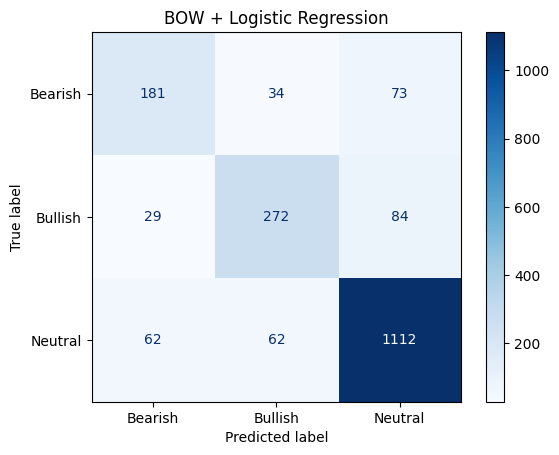

In [ ]:
pipe_bow_logit = Pipeline([
    ("bow", pipeline_bow),
    ("clf", LogisticRegression(class_weight="balanced", random_state=SEED))
])

pipe_bow_logit.fit(X_train, y_train)

y_pred_bow = pipe_bow_logit.predict(X_val)
evaluate_multiclass(y_val, y_pred_bow, "BOW + Logistic Regression")
add_to_leaderboard("BOW + Logistic Regression", y_val, y_pred_bow, leaderboard_logit)

### FinBERT

FinBERT + Logistic Regression
Accuracy: 0.7863
Macro-F1 : 0.7359
              precision    recall  f1-score   support

     Bearish      0.584     0.726     0.647       288
     Bullish      0.661     0.764     0.708       385
     Neutral      0.902     0.807     0.852      1236

    accuracy                          0.786      1909
   macro avg      0.716     0.766     0.736      1909
weighted avg      0.806     0.786     0.792      1909



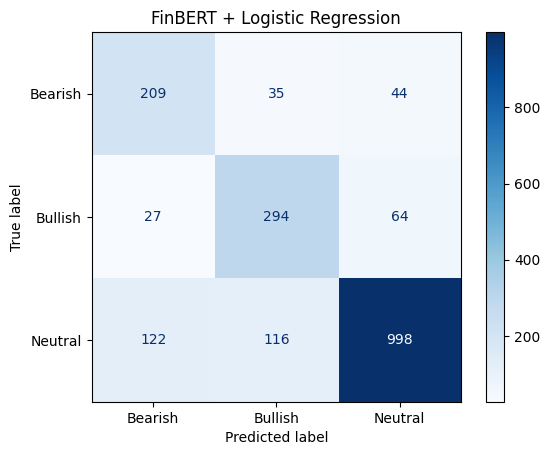

In [ ]:
clr = LogisticRegression(class_weight='balanced', random_state=SEED, max_iter=1000)
clr.fit(X_train_emb_finbert, y_train)

y_pred_finbert = clr.predict(X_val_emb_finbert)
evaluate_multiclass(y_val, y_pred_finbert, "FinBERT + Logistic Regression")
add_to_leaderboard("FinBERT + Logistic Regression", y_val, y_pred_finbert, leaderboard_logit)

### RoBERTa

RoBERTa + Logistic Regression
Accuracy: 0.7957
Macro-F1 : 0.7518
              precision    recall  f1-score   support

     Bearish      0.616     0.767     0.683       288
     Bullish      0.674     0.769     0.718       385
     Neutral      0.902     0.811     0.854      1236

    accuracy                          0.796      1909
   macro avg      0.731     0.782     0.752      1909
weighted avg      0.813     0.796     0.801      1909



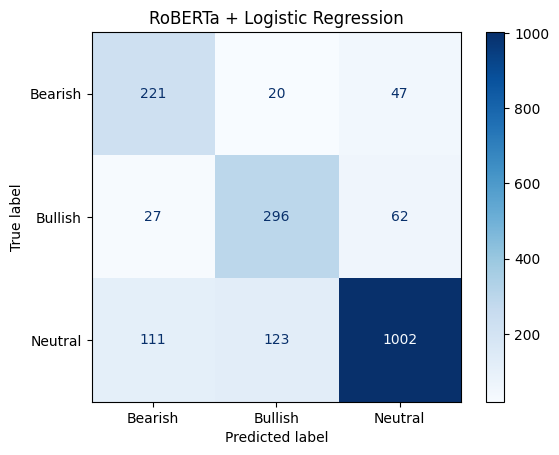

In [ ]:
clr = LogisticRegression(class_weight='balanced', random_state=SEED, max_iter= 1000)
clr.fit(X_train_emb_roberta, y_train)

y_pred_roberta= clr.predict(X_val_emb_roberta)
evaluate_multiclass(y_val, y_pred_roberta, "RoBERTa + Logistic Regression")
add_to_leaderboard("RoBERTa + Logistic Regression", y_val, y_pred_roberta, leaderboard_logit)

### Fine-tuned RoBERTa

fine-Tuned RoBERTa + Logistic Regression
Accuracy: 0.8638
Macro-F1 : 0.8293
              precision    recall  f1-score   support

     Bearish      0.712     0.823     0.763       288
     Bullish      0.803     0.839     0.821       385
     Neutral      0.928     0.881     0.904      1236

    accuracy                          0.864      1909
   macro avg      0.814     0.848     0.829      1909
weighted avg      0.870     0.864     0.866      1909



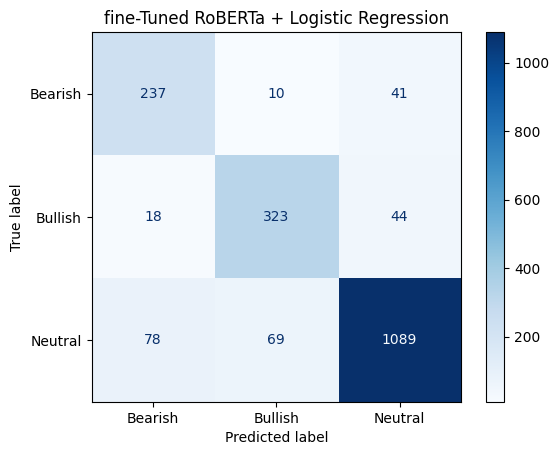

In [ ]:
clr = LogisticRegression(class_weight='balanced', random_state=SEED, max_iter= 1000)
clr.fit(X_train_emb_finetuned, y_train)

y_pred_finetuned= clr.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred_finetuned, "fine-Tuned RoBERTa + Logistic Regression")
add_to_leaderboard("Fine-tuned RoBERTa + Logistic Regression", y_val, y_pred_finetuned, leaderboard_logit)

Best C: {'C': 0.01}
Fine-tuned RoBERTa + Logistic Regression (tuned)
Accuracy: 0.8743
Macro-F1 : 0.8487
              precision    recall  f1-score   support

     Bearish      0.718     0.885     0.793       288
     Bullish      0.827     0.870     0.848       385
     Neutral      0.939     0.873     0.905      1236

    accuracy                          0.874      1909
   macro avg      0.828     0.876     0.849      1909
weighted avg      0.883     0.874     0.877      1909



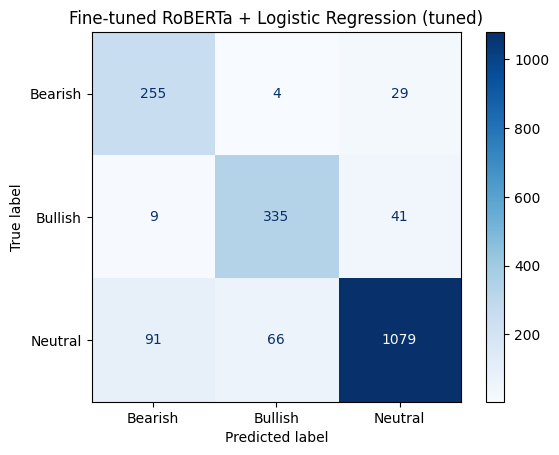

In [ ]:
param_grid = {
    "C": [0.001, 0.01, 0.1, 1, 3, 10, 30]
}

clr = LogisticRegression(
    class_weight="balanced",
    random_state=SEED,
    max_iter=1000,
    solver="lbfgs",
)

gs = GridSearchCV(
    clr,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
)

gs.fit(X_train_emb_finetuned, y_train)

best_clr = gs.best_estimator_
print("Best C:", gs.best_params_)

y_pred_finetuned = best_clr.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred_finetuned,
                    "Fine-tuned RoBERTa + Logistic Regression (tuned)")
add_to_leaderboard(
    "Fine-tuned RoBERTa + LogReg (tuned)",
    y_val,
    y_pred_finetuned,
    leaderboard_logit
)


In [ ]:
leaderboard_logit_df = pd.DataFrame(leaderboard_logit).sort_values("f1_macro", ascending=False).reset_index(drop=True)
leaderboard_logit_df.to_pickle("leaderboard_logit.pkl")
leaderboard_logit_df

,model,accuracy,precision_macro,recall_macro,f1_macro
0,Fine-tuned RoBERTa + LogReg (C tuned),0.874280,0.828183,0.876175,0.848693
1,Fine-tuned RoBERTa + Logistic Regression,0.863803,0.814264,0.847649,0.829286
2,BOW + Logistic Regression,0.819801,0.760284,0.744881,0.752232
3,RoBERTa + Logistic Regression,0.795705,0.730583,0.782291,0.751819
4,TF-IDF + Logistic Regression,0.811420,0.743556,0.755087,0.749100
5,FinBERT + Logistic Regression,0.786276,0.715608,0.765591,0.735919
6,Word2vec + Logistic Regression,0.564170,0.471628,0.492538,0.472822


## Random Forest

In [ ]:
leaderboard_rf = []

### Word2vec

Word2vec + Random Forest
Accuracy: 0.703
Macro-F1 : 0.4987
              precision    recall  f1-score   support

     Bearish      0.487     0.135     0.212       288
     Bullish      0.522     0.403     0.455       385
     Neutral      0.749     0.929     0.829      1236

    accuracy                          0.703      1909
   macro avg      0.586     0.489     0.499      1909
weighted avg      0.664     0.703     0.661      1909



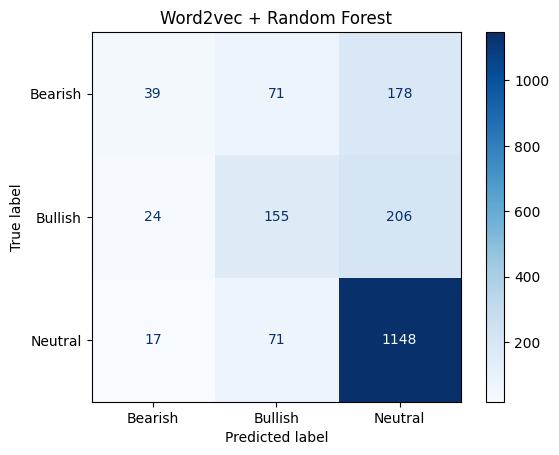

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=SEED)
rfc.fit(X_train_w2v, y_train)

y_pred = rfc.predict(X_val_w2v)
evaluate_multiclass(y_val, y_pred, "Word2vec + Random Forest")
add_to_leaderboard("Word2vec + Random Forest", y_val, y_pred, leaderboard_rf)

### TD-IF

TF-IDF + Random Forest
Accuracy: 0.7941
Macro-F1 : 0.6844
              precision    recall  f1-score   support

     Bearish      0.856     0.392     0.538       288
     Bullish      0.795     0.545     0.647       385
     Neutral      0.788     0.965     0.868      1236

    accuracy                          0.794      1909
   macro avg      0.813     0.634     0.684      1909
weighted avg      0.800     0.794     0.774      1909



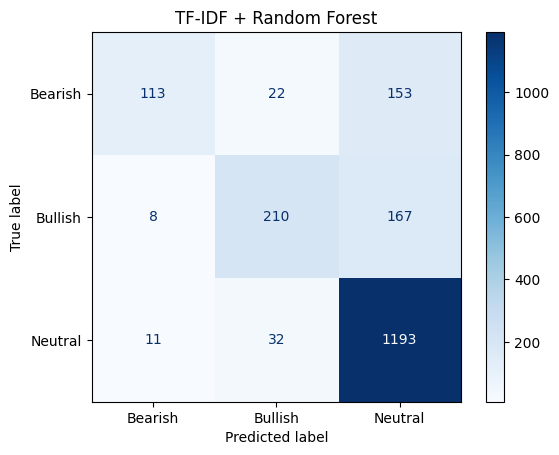

In [ ]:
pipe_tfidf_rf = Pipeline([
    ("tfidf", pipeline_tfid),
    ("rfc", RandomForestClassifier(class_weight="balanced", random_state=SEED))
])

pipe_tfidf_rf.fit(X_train, y_train)
y_pred = pipe_tfidf_rf.predict(X_val)
evaluate_multiclass(y_val, y_pred, "TF-IDF + Random Forest")
add_to_leaderboard("TF-IDF + Random Forest", y_val, y_pred, leaderboard_rf)

### BOW

BOW + Random Forest
Accuracy: 0.7973
Macro-F1 : 0.6891
              precision    recall  f1-score   support

     Bearish      0.835     0.403     0.543       288
     Bullish      0.790     0.556     0.652       385
     Neutral      0.795     0.964     0.872      1236

    accuracy                          0.797      1909
   macro avg      0.806     0.641     0.689      1909
weighted avg      0.800     0.797     0.778      1909



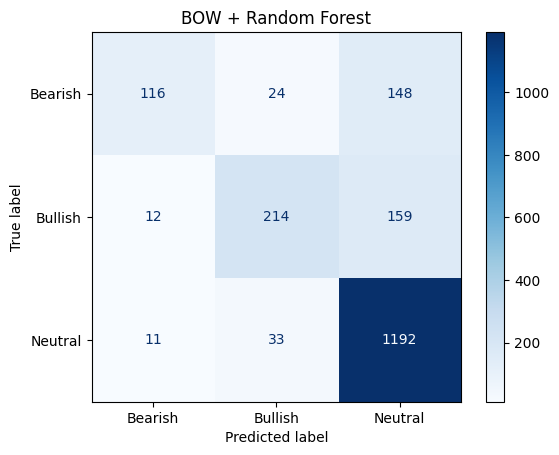

In [ ]:
pipe_bow_rf = Pipeline([
    ("bow", pipeline_bow),
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=SEED))
])

pipe_bow_rf.fit(X_train, y_train)
y_pred = pipe_bow_rf.predict(X_val)
pipe_bow_rf.fit(X_train, y_train)
evaluate_multiclass(y_val, y_pred, "BOW + Random Forest")
add_to_leaderboard("BOW + Random Forest", y_val, y_pred, leaderboard_rf)

### FinBERT

FinBERT + Random Forest
Accuracy: 0.8051
Macro-F1 : 0.7189
              precision    recall  f1-score   support

     Bearish      0.770     0.524     0.624       288
     Bullish      0.825     0.551     0.660       385
     Neutral      0.806     0.950     0.872      1236

    accuracy                          0.805      1909
   macro avg      0.801     0.675     0.719      1909
weighted avg      0.805     0.805     0.792      1909



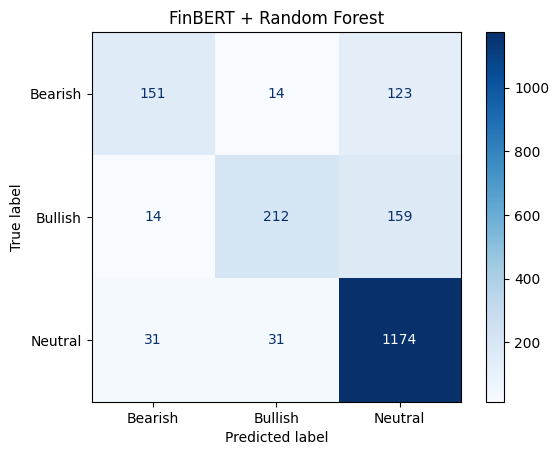

In [ ]:
rfc = RandomForestClassifier(class_weight="balanced", random_state=SEED)
rfc.fit(X_train_emb_finbert, y_train)

y_pred = rfc.predict(X_val_emb_finbert)
evaluate_multiclass(y_val, y_pred, "FinBERT + Random Forest")
add_to_leaderboard("FinBERT + Random Forest", y_val, y_pred, leaderboard_rf)

### RoBERTa

RoBERTa + Random Forest
Accuracy: 0.8114
Macro-F1 : 0.7302
              precision    recall  f1-score   support

     Bearish      0.803     0.524     0.634       288
     Bullish      0.862     0.566     0.683       385
     Neutral      0.804     0.955     0.873      1236

    accuracy                          0.811      1909
   macro avg      0.823     0.682     0.730      1909
weighted avg      0.815     0.811     0.799      1909



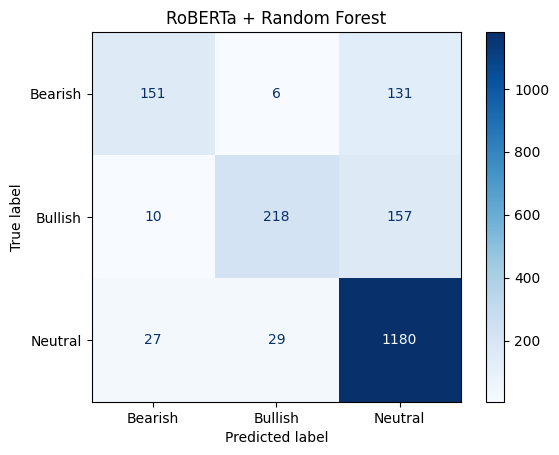

In [ ]:
rfc = RandomForestClassifier(class_weight="balanced", random_state=SEED)
rfc.fit(X_train_emb_roberta, y_train)

y_pred = rfc.predict(X_val_emb_roberta)
evaluate_multiclass(y_val, y_pred, "RoBERTa + Random Forest")
add_to_leaderboard("RoBERTa + Random Forest", y_val, y_pred, leaderboard_rf)

### Fine-tuned RoBERTa

Fine-tuned RoBERTa + Random Forest
Accuracy: 0.8837
Macro-F1 : 0.8496
              precision    recall  f1-score   support

     Bearish      0.830     0.764     0.796       288
     Bullish      0.880     0.797     0.837       385
     Neutral      0.896     0.939     0.917      1236

    accuracy                          0.884      1909
   macro avg      0.869     0.833     0.850      1909
weighted avg      0.883     0.884     0.882      1909



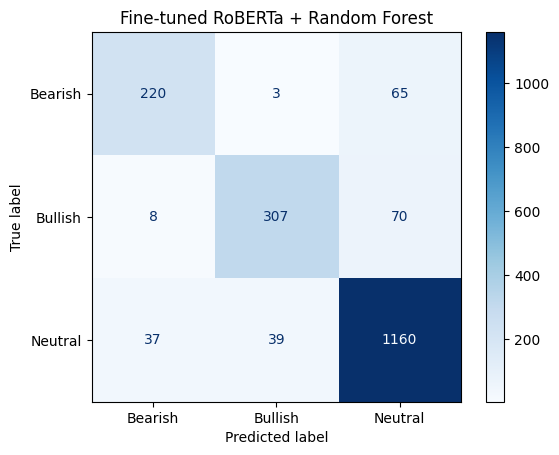

In [ ]:
rfc = RandomForestClassifier(class_weight="balanced", random_state=SEED)
rfc.fit(X_train_emb_finetuned, y_train)

y_pred = rfc.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred, "Fine-tuned RoBERTa + Random Forest")
add_to_leaderboard("Fine-tuned RoBERTa + Random Forest", y_val, y_pred, leaderboard_rf)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best CV f1_macro: 0.9042640083745325
Best params: {'n_estimators': 100, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 10}
Fine-tuned RoBERTa + Random Forest (tuned)
Accuracy: 0.8795
Macro-F1 : 0.8486
              precision    recall  f1-score   support

     Bearish      0.794     0.802     0.798       288
     Bullish      0.852     0.821     0.836       385
     Neutral      0.908     0.916     0.912      1236

    accuracy                          0.880      1909
   macro avg      0.851     0.846     0.849      1909
weighted avg      0.879     0.880     0.879      1909



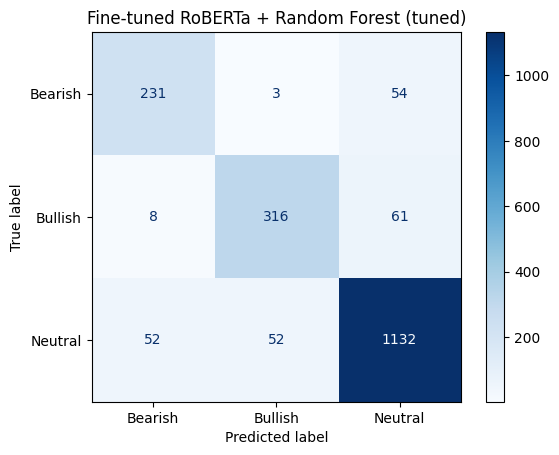

In [ ]:
# Hyper-parameter tuning
rfc = RandomForestClassifier(
    class_weight="balanced",
    random_state=SEED,
    n_jobs=-1
)

param_dist = {
    "n_estimators": [100, 120, 150],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 4, 5, 10],
    "min_samples_leaf": [1, 2, 4, 8]
}

search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    random_state=SEED,
    refit=True
)

search.fit(X_train_emb_finetuned, y_train)

best_rfc = search.best_estimator_
print("Best CV f1_macro:", search.best_score_)
print("Best params:", search.best_params_)

y_pred = best_rfc.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred, "Fine-tuned RoBERTa + Random Forest (tuned)")
add_to_leaderboard("Fine-tuned RoBERTa + Random Forest (tuned)", y_val, y_pred, leaderboard_rf)


In [ ]:
leaderboard_rf_df = pd.DataFrame(leaderboard_rf).sort_values("f1_macro", ascending=False).reset_index(drop=True)
leaderboard_rf_df.to_pickle("leaderboard_rf.pkl")
leaderboard_rf_df

,model,accuracy,precision_macro,recall_macro,f1_macro
0,Fine-tuned RoBERTa + Random Forest,0.883709,0.868533,0.833268,0.849602
1,Fine-tuned RoBERTa + Random Forest (tuned),0.879518,0.851115,0.846240,0.848569
2,RoBERTa + Random Forest,0.811420,0.822889,0.681744,0.730207
3,FinBERT + Random Forest,0.805134,0.800543,0.674931,0.718872
4,BOW + Random Forest,0.797276,0.806466,0.641008,0.689143
5,TF-IDF + Random Forest,0.794133,0.813338,0.634342,0.684399
6,Word2vec + Random Forest,0.702986,0.586244,0.488939,0.498661


## Linear SVC

In [ ]:
leaderboard_svc = []

### Word2vec

Word2vec + LinearSVC
Accuracy: 0.6679
Macro-F1 : 0.4817
              precision    recall  f1-score   support

     Bearish      0.330     0.115     0.170       288
     Bullish      0.450     0.499     0.473       385
     Neutral      0.760     0.850     0.802      1236

    accuracy                          0.668      1909
   macro avg      0.513     0.488     0.482      1909
weighted avg      0.632     0.668     0.640      1909



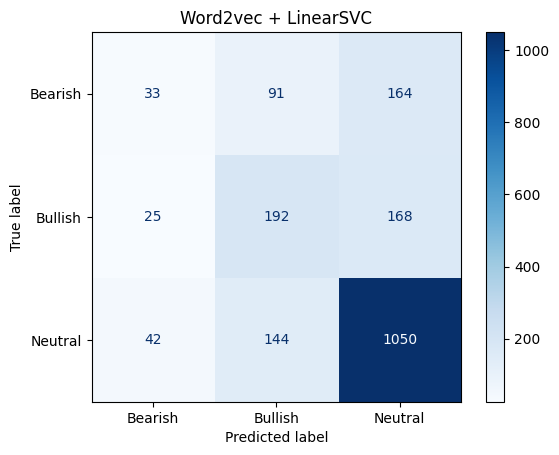

In [ ]:
svc = LinearSVC(class_weight="balanced", random_state=SEED)
svc.fit(X_train_w2v, y_train)

y_pred = svc.predict(X_val_w2v)
evaluate_multiclass(y_val, y_pred, "Word2vec + LinearSVC")
add_to_leaderboard("Word2vec + LinearSVC", y_val, y_pred, leaderboard_svc)

### TD-IF

TF-IDF + LinearSVC
Accuracy: 0.8208
Macro-F1 : 0.7498
              precision    recall  f1-score   support

     Bearish      0.702     0.604     0.649       288
     Bullish      0.731     0.691     0.710       385
     Neutral      0.869     0.912     0.890      1236

    accuracy                          0.821      1909
   macro avg      0.767     0.736     0.750      1909
weighted avg      0.816     0.821     0.817      1909



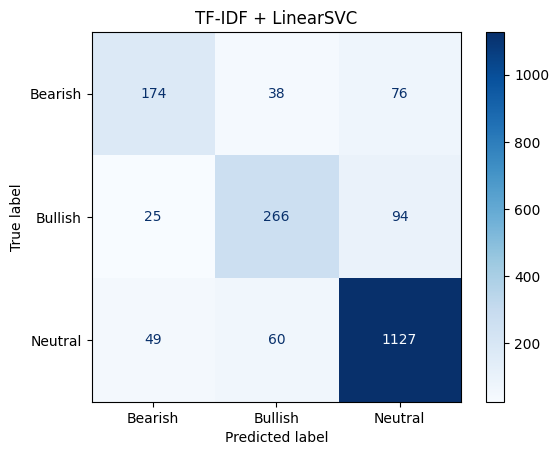

In [ ]:
pipe_tfidf_svm = Pipeline([
    ("tfidf", pipeline_tfid),
    ("clf", LinearSVC(class_weight="balanced", random_state=SEED))
])

pipe_tfidf_svm.fit(X_train, y_train)
y_pred = pipe_tfidf_svm.predict(X_val)
evaluate_multiclass(y_val, y_pred, "TF-IDF + LinearSVC")
add_to_leaderboard("TF-IDF + LinearSVC", y_val, y_pred, leaderboard_svc)

### BOW

BOW + LinearSVC
Accuracy: 0.8041
Macro-F1 : 0.7304
              precision    recall  f1-score   support

     Bearish      0.651     0.590     0.619       288
     Bullish      0.731     0.665     0.697       385
     Neutral      0.854     0.897     0.875      1236

    accuracy                          0.804      1909
   macro avg      0.746     0.717     0.730      1909
weighted avg      0.799     0.804     0.801      1909



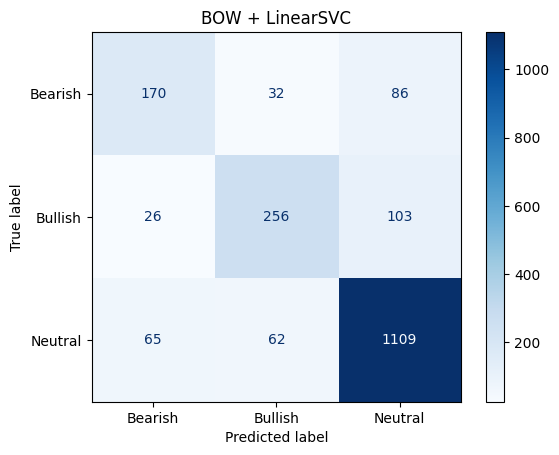

In [ ]:
pipe_bow_svm = Pipeline([
    ("bow", pipeline_bow),
    ("clf", LinearSVC(class_weight="balanced", random_state=42))
])

pipe_bow_svm.fit(X_train, y_train)
y_pred = pipe_bow_svm.predict(X_val)
evaluate_multiclass(y_val, y_pred, "BOW + LinearSVC")
add_to_leaderboard("BOW + LinearSVC", y_val, y_pred, leaderboard_svc)

### FinBERT

FinBERT + LinearSVC
Accuracy: 0.7988
Macro-F1 : 0.7385
              precision    recall  f1-score   support

     Bearish      0.628     0.681     0.653       288
     Bullish      0.687     0.701     0.694       385
     Neutral      0.880     0.857     0.868      1236

    accuracy                          0.799      1909
   macro avg      0.732     0.746     0.738      1909
weighted avg      0.803     0.799     0.801      1909



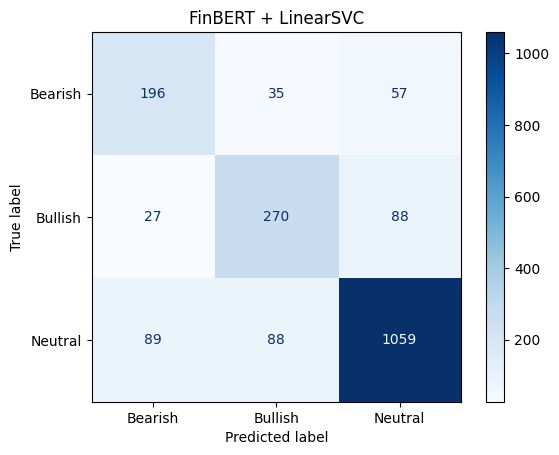

In [ ]:
svc.fit(X_train_emb_finbert, y_train)
y_pred = svc.predict(X_val_emb_finbert)

evaluate_multiclass(y_val, y_pred, "FinBERT + LinearSVC")
add_to_leaderboard("FinBERT + LinearSVC", y_val, y_pred, leaderboard_svc)

### RoBERTa

RoBERTa + LinearSVC
Accuracy: 0.8119
Macro-F1 : 0.7611
              precision    recall  f1-score   support

     Bearish      0.651     0.719     0.683       288
     Bullish      0.720     0.740     0.730       385
     Neutral      0.885     0.856     0.870      1236

    accuracy                          0.812      1909
   macro avg      0.752     0.772     0.761      1909
weighted avg      0.817     0.812     0.814      1909



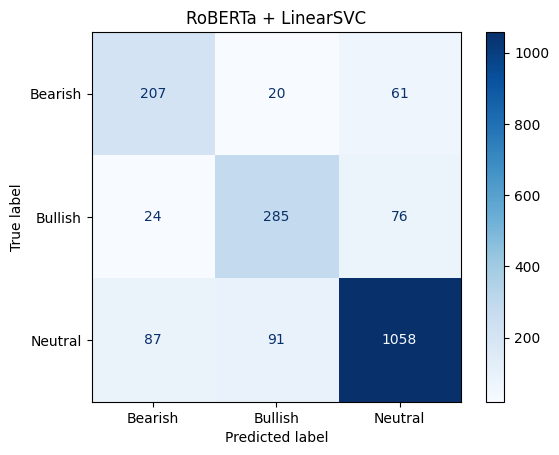

In [ ]:
scv = LinearSVC(class_weight="balanced", random_state=SEED)
scv.fit(X_train_emb_roberta, y_train)

y_pred = scv.predict(X_val_emb_roberta)
evaluate_multiclass(y_val, y_pred, "RoBERTa + LinearSVC")
add_to_leaderboard("RoBERTa + LinearSVC", y_val, y_pred, leaderboard_svc)

### Fine-tuned RoBERTa

Fine-tuned RoBERTa + LinearSVC
Accuracy: 0.8601
Macro-F1 : 0.8205
              precision    recall  f1-score   support

     Bearish      0.736     0.774     0.755       288
     Bullish      0.805     0.803     0.804       385
     Neutral      0.908     0.898     0.903      1236

    accuracy                          0.860      1909
   macro avg      0.816     0.825     0.820      1909
weighted avg      0.861     0.860     0.861      1909



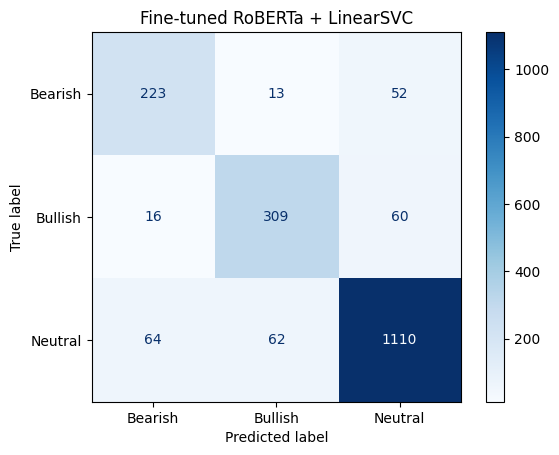

In [ ]:
scv = LinearSVC(class_weight="balanced", random_state=SEED)
scv.fit(X_train_emb_finetuned, y_train)

y_pred = scv.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred, "Fine-tuned RoBERTa + LinearSVC")
add_to_leaderboard("Fine-tuned RoBERTa + LinearSVC", y_val, y_pred, leaderboard_svc)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'C': np.float64(0.003359818286283781), 'loss': 'hinge', 'tol': np.float64(0.0071144760093434225)}
CV best score: 0.9029766995297875
Fine-tuned RoBERTa + LinearSVC (tuned)
Accuracy: 0.8795
Macro-F1 : 0.8512
              precision    recall  f1-score   support

     Bearish      0.773     0.840     0.805       288
     Bullish      0.839     0.836     0.837       385
     Neutral      0.920     0.902     0.911      1236

    accuracy                          0.880      1909
   macro avg      0.844     0.860     0.851      1909
weighted avg      0.881     0.880     0.880      1909



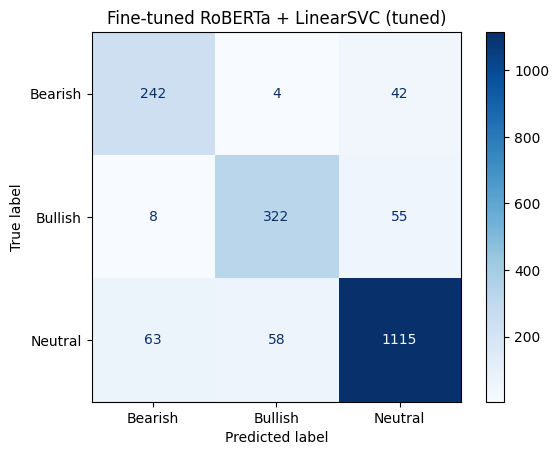

In [ ]:
svc = LinearSVC(class_weight='balanced',random_state=SEED)

param_dist = {
    "C": np.logspace(-5, 3, 20),
    "loss": ["squared_hinge", "hinge"],
     "tol": loguniform(1e-5, 1e-2)
}

search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=cv,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_emb_finetuned, y_train)

best_svc = search.best_estimator_
print("Best params:", search.best_params_)
print("CV best score:", search.best_score_)

y_pred = best_svc.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred, "Fine-tuned RoBERTa + LinearSVC (tuned)")
add_to_leaderboard("Fine-tuned RoBERTa + LinearSVC (tuned)", y_val, y_pred, leaderboard_svc)

In [ ]:
leaderboard_svc_df = pd.DataFrame(leaderboard_svc).sort_values("f1_macro", ascending=False).reset_index(drop=True)
leaderboard_svc_df.to_pickle("leaderboard_svc.pkl")
leaderboard_svc_df

,model,accuracy,precision_macro,recall_macro,f1_macro
0,Fine-tuned RoBERTa + LinearSVC (tuned),0.879518,0.843891,0.859582,0.851241
1,Fine-tuned RoBERTa + LinearSVC,0.860136,0.816336,0.824987,0.820489
2,RoBERTa + LinearSVC,0.811943,0.751999,0.771666,0.761142
3,TF-IDF + LinearSVC,0.820849,0.767103,0.735629,0.749796
4,FinBERT + LinearSVC,0.798848,0.731599,0.746217,0.738485
5,BOW + LinearSVC,0.804086,0.745720,0.717487,0.730401
6,Word2vec + LinearSVC,0.667889,0.513139,0.487600,0.481716


## XBoost

In [ ]:
leaderboard_xgb = []

### TF-ID

TF-IDF + XGBoost
Accuracy: 0.7968
Macro-F1 : 0.7033
              precision    recall  f1-score   support

     Bearish      0.787     0.462     0.582       288
     Bullish      0.778     0.574     0.661       385
     Neutral      0.802     0.944     0.867      1236

    accuracy                          0.797      1909
   macro avg      0.789     0.660     0.703      1909
weighted avg      0.795     0.797     0.782      1909



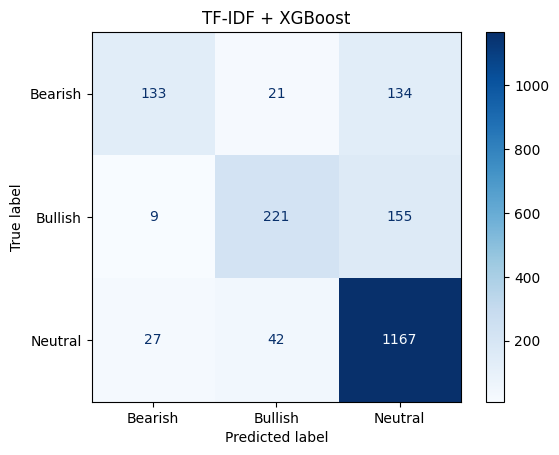

In [ ]:
pipe_tfid_xgb = Pipeline([
    ("tfidf", pipeline_tfid),
    ("clf", XGBClassifier( random_state=SEED))
])

pipe_tfid_xgb.fit(X_train, y_train)
y_pred = pipe_tfid_xgb.predict(X_val)
evaluate_multiclass(y_val, y_pred, "TF-IDF + XGBoost")
add_to_leaderboard("TF-IDF + XGBoost", y_val, y_pred, leaderboard_xgb)

### RoBERTa

RoBERTa + XGBoost
Accuracy: 0.8449
Macro-F1 : 0.7915
              precision    recall  f1-score   support

     Bearish      0.797     0.667     0.726       288
     Bullish      0.827     0.694     0.754       385
     Neutral      0.858     0.934     0.894      1236

    accuracy                          0.845      1909
   macro avg      0.827     0.765     0.791      1909
weighted avg      0.842     0.845     0.841      1909



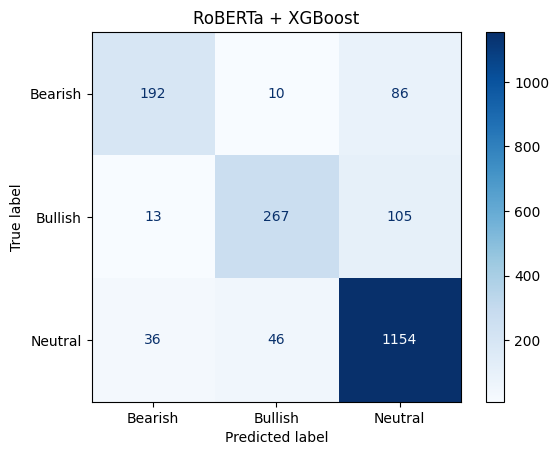

In [ ]:
xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train_emb_roberta, y_train)

y_pred = xgb.predict(X_val_emb_roberta)
evaluate_multiclass(y_val, y_pred, "RoBERTa + XGBoost")
add_to_leaderboard("RoBERTa + XGBoost", y_val, y_pred, leaderboard_xgb)

### Fine-tuned RoBERTa


RoBERTa + XGBoost
Accuracy: 0.8827
Macro-F1 : 0.8495
              precision    recall  f1-score   support

     Bearish      0.805     0.788     0.796       288
     Bullish      0.866     0.808     0.836       385
     Neutral      0.905     0.928     0.916      1236

    accuracy                          0.883      1909
   macro avg      0.859     0.841     0.850      1909
weighted avg      0.882     0.883     0.882      1909



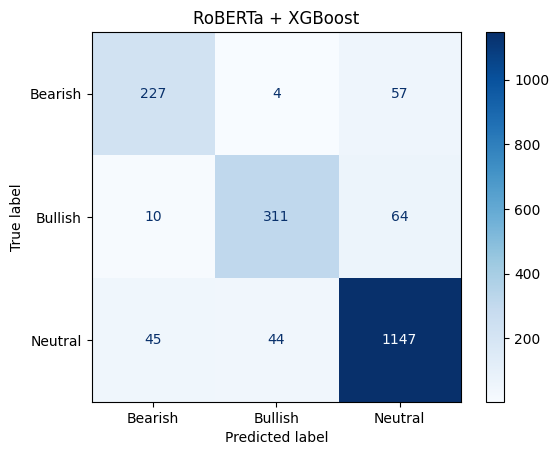

In [ ]:
xgb = XGBClassifier(random_state=SEED)
xgb.fit(X_train_emb_finetuned, y_train)

y_pred = xgb.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred, "RoBERTa + XGBoost")
add_to_leaderboard("Fine-tuned RoBERTa + XGBoost", y_val, y_pred, leaderboard_xgb)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'colsample_bytree': np.float64(0.7039794883479599), 'learning_rate': np.float64(0.14724294724810286), 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 108, 'subsample': np.float64(0.7047898756660642)}
CV best score: 0.905240759225542
Fine-tuned RoBERTa + XGBoost (tuned)
Accuracy: 0.8837
Macro-F1 : 0.8505
              precision    recall  f1-score   support

     Bearish      0.805     0.788     0.796       288
     Bullish      0.880     0.800     0.838       385
     Neutral      0.902     0.932     0.917      1236

    accuracy                          0.884      1909
   macro avg      0.862     0.840     0.850      1909
weighted avg      0.883     0.884     0.883      1909



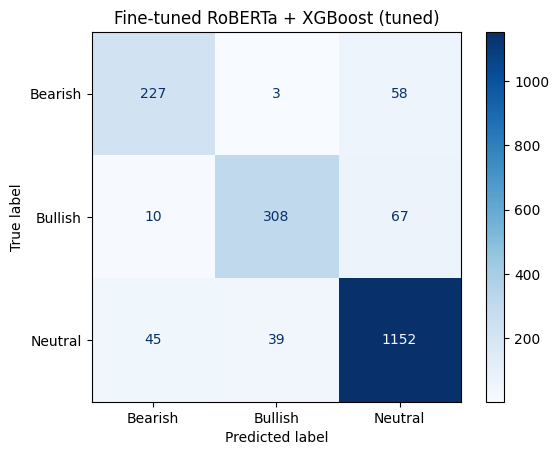

In [ ]:
xgb = XGBClassifier(
    objective="multi:softmax",  # since no need for proba
    num_class=3,
    eval_metric="mlogloss", # metric for classification
    tree_method="hist",
    random_state=SEED,
)

param_dist = {
    "n_estimators": randint(100, 300),
    "learning_rate": loguniform(1e-3, 2e-1),
    "max_depth": randint(2, 8),
    "min_child_weight": randint(1, 10),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
}

search = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=20, scoring="f1_macro", cv=cv,
    n_jobs=-1, verbose=1, random_state=SEED
)

search.fit(X_train_emb_finetuned, y_train)
best_xgb = search.best_estimator_

print("Best params:", search.best_params_)
print("CV best score:", search.best_score_)

y_pred = best_xgb.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred, "Fine-tuned RoBERTa + XGBoost (tuned)")
add_to_leaderboard("Fine-tuned RoBERTa + XGBoost (tuned)", y_val, y_pred, leaderboard_xgb)

In [ ]:
leaderboard_xgb_df = pd.DataFrame(leaderboard_xgb).sort_values("f1_macro", ascending=False).reset_index(drop=True)
leaderboard_xgb_df.to_pickle("leaderboard_xgb.pkl")
leaderboard_xgb_df

,model,accuracy,precision_macro,recall_macro,f1_macro
0,Fine-tuned RoBERTa + XGBoost (tuned),0.883709,0.862360,0.840078,0.850473
1,Fine-tuned RoBERTa + XGBoost,0.882661,0.858611,0.841327,0.849549
2,RoBERTa + XGBoost,0.844945,0.827099,0.764610,0.791454
3,TF-IDF + XGBoost,0.796752,0.788887,0.660002,0.703253


## Decoder

In [ ]:
leaderboard_decoder = []

In [ ]:
MODEL = "HuggingFaceTB/SmolLM2-1.7B-Instruct" #doens't need a token for access

tok = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForCausalLM.from_pretrained(
    MODEL,
    device_map="auto",
    torch_dtype=torch.float16,
)

tok.pad_token = tok.eos_token
model.config.pad_token_id = tok.eos_token_id

gen = pipeline("text-generation", model=model, tokenizer=tok)


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
label_map = {"bearish": 0, "bullish": 1, "neutral": 2}

def make_prompt(tweet: str) -> str:
    return (
        "Classify the financial sentiment of the tweet.\n"
        "Return exactly one word: Bearish, Bullish, or Neutral.\n"
        f"Tweet: {tweet}\n"
        "Answer:"
    )

def llm_predict(texts, batch_size=16):
    preds = []
    for i in range(0, len(texts), batch_size):
        prompts = [make_prompt(t) for t in texts[i:i+batch_size]]

        outs = gen(
            prompts,
            max_new_tokens=3,
            do_sample=False,
            temperature=0.0,
            return_full_text=False,
            pad_token_id=tok.eos_token_id,
        )

        for o in outs:
            # pipeline returns list-of-dicts per input
            txt = o[0]["generated_text"].strip().lower()
            txt = re.sub(r"[^a-z]", "", txt)  # clean punctuation
            preds.append(label_map.get(txt, 2))  # default neutral

    return preds


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Llama-3.2-1B Instruct (prompt)
Accuracy: 0.6008
Macro-F1 : 0.4056
              precision    recall  f1-score   support

     Bearish      0.396     0.212     0.276       288
     Bullish      0.309     0.156     0.207       385
     Neutral      0.657     0.830     0.734      1236

    accuracy                          0.601      1909
   macro avg      0.454     0.399     0.406      1909
weighted avg      0.548     0.601     0.558      1909



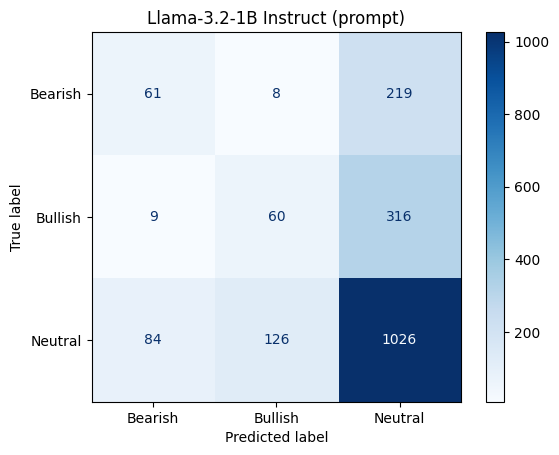

In [ ]:
# It mentions another model I tried running earlier, but it's a typo
# the results shown are from SmolLM2-1.7B-Instruct
y_pred = llm_predict(X_val_tx)
evaluate_multiclass(y_val, y_pred, "SmolLM2-1.7B-Instruct (prompt)")
add_to_leaderboard("SmolLM2-1.7B-Instruct (prompt)", y_val, y_pred, leaderboard_decoder)

## LeaderBoard

In [ ]:
leaderboards = {
    "Transformer Encoder": leaderboard_transformer,
    "Logit": leaderboard_logit,
    "LinearSVC": leaderboard_svc,
    "Random Forest": leaderboard_rf,
    "XGBoost": leaderboard_xgb,
    "Decoder": leaderboard_decoder
}

# Picks the 2 best from each model
leaderboard = pd.concat(
    [pd.DataFrame(rows).assign(model_type=t).nlargest(2, "f1_macro")
     for t, rows in leaderboards.items() if rows],
    ignore_index=True
).sort_values("f1_macro", ascending=False).reset_index(drop=True)

leaderboard

,model,accuracy,precision_macro,recall_macro,f1_macro,model_type
0,Fine-tuned RoBERTa + LinearSVC (tuned),0.879518,0.843891,0.859582,0.851241,LinearSVC
1,Fine-tuned RoBERTa + XGBoost (tuned),0.883709,0.862360,0.840078,0.850473,XGBoost
2,Fine-tuned RoBERTa + Random Forest,0.883709,0.868533,0.833268,0.849602,Random Forest
3,Fine-tuned RoBERTa + XGBoost,0.882661,0.858611,0.841327,0.849549,XGBoost
4,Fined-tuned RoBERTa,0.881090,0.856813,0.842585,0.849264,Transformer Encoder
5,Fine-tuned RoBERTa + LogReg (C tuned),0.874280,0.828183,0.876175,0.848693,Logit
6,Fine-tuned RoBERTa + Random Forest (tuned),0.879518,0.851115,0.846240,0.848569,Random Forest
7,Fine-tuned RoBERTa + Logistic Regression,0.863803,0.814264,0.847649,0.829286,Logit
8,Fine-tuned RoBERTa + LinearSVC,0.860136,0.816336,0.824987,0.820489,LinearSVC
9,Fined-tuned FinancialBERT,0.861184,0.830631,0.801189,0.814885,Transformer Encoder


## Hyper-parameter tune further

For the best models (Linear SVC, XGBoost, Random Forest), we do more hyperparameter tuning to find the best and more stable model configurations.

We increased cross-validation folds to 5 and the number of iterations to 40 to get more stable results. However, for XGBoost and Random Forest, the number of tuning iterations was capped at 20 due to computational constraints.

In addition, since linear models can be sensitive to feature scaling, a scaled variant of LinearSVC was also evaluated.


In [ ]:
leaderboard_final=[]
cv_extra= StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'C': np.float64(0.003359818286283781), 'loss': 'squared_hinge', 'tol': np.float64(0.0007411299781083245)}
CV best score: 0.9058291105091195
Fine-tuned RoBERTa + LinearSVC (extra-tuned)
Accuracy: 0.8827
Macro-F1 : 0.8543
              precision    recall  f1-score   support

     Bearish      0.772     0.837     0.803       288
     Bullish      0.850     0.842     0.846       385
     Neutral      0.921     0.906     0.914      1236

    accuracy                          0.883      1909
   macro avg      0.848     0.862     0.854      1909
weighted avg      0.884     0.883     0.883      1909



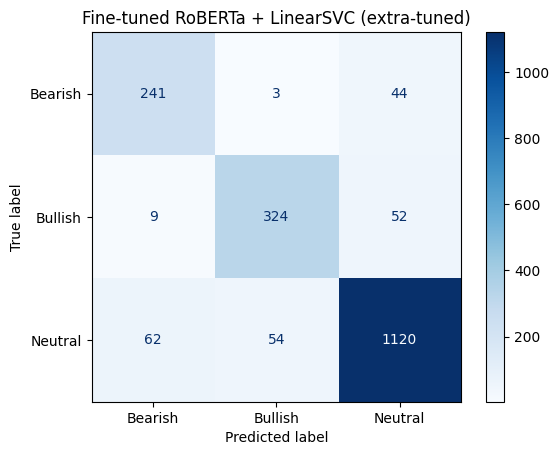

In [ ]:
svc = LinearSVC(class_weight='balanced',random_state=SEED)

param_dist = {
    "C": np.logspace(-5, 3, 20),
    "loss": ["squared_hinge", "hinge"],
     "tol": loguniform(1e-5, 1e-2)
}

search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_dist,
    n_iter=40,
    scoring="f1_macro",
    cv=cv_extra,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_emb_finetuned, y_train)

best_svc = search.best_estimator_
print("Best params:", search.best_params_)
print("CV best score:", search.best_score_)

y_pred = best_svc.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred, "Fine-tuned RoBERTa + LinearSVC (extra-tuned)")
add_to_leaderboard("Fine-tuned RoBERTa + LinearSVC (extra-tuned)", y_val, y_pred, leaderboard_final)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best params: {'svc__C': np.float64(0.0004832930238571752), 'svc__loss': 'squared_hinge', 'svc__tol': np.float64(0.0010988100318524605)}
CV best score: 0.9054410091095312
Fine-tuned RoBERTa + LinearSVC (extra-tuned-scaled)
Accuracy: 0.879
Macro-F1 : 0.8497
              precision    recall  f1-score   support

     Bearish      0.764     0.833     0.797       288
     Bullish      0.851     0.831     0.841       385
     Neutral      0.917     0.905     0.911      1236

    accuracy                          0.879      1909
   macro avg      0.844     0.856     0.850      1909
weighted avg      0.881     0.879     0.880      1909



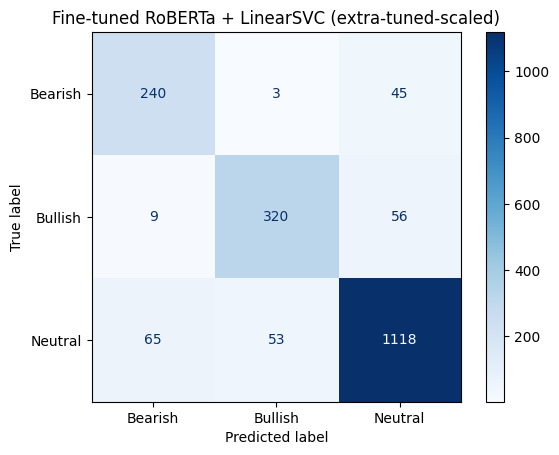

In [ ]:
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", LinearSVC(class_weight="balanced", random_state=SEED, max_iter=10000))
])

param_dist = {
    "svc__C": np.logspace(-5, 3, 20),
    "svc__loss": ["squared_hinge", "hinge"],
    "svc__tol": loguniform(1e-5, 1e-2),
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="f1_macro",
    cv=cv_extra,
    random_state=SEED,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train_emb_finetuned, y_train)

best_svc = search.best_estimator_
print("Best params:", search.best_params_)
print("CV best score:", search.best_score_)

y_pred = best_svc.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred, "Fine-tuned RoBERTa + LinearSVC (extra-tuned-scaled)")
add_to_leaderboard("Fine-tuned RoBERTa + LinearSVC (extra-tuned-scaled)", y_val, y_pred, leaderboard_final)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'colsample_bytree': np.float64(0.9915136286167311), 'learning_rate': np.float64(0.08982064582178413), 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 241, 'subsample': np.float64(0.8481386789093172)}
CV best score: 0.9067143219277893
Fine-tuned RoBERTa + XGBoost (extra-tuned)
Accuracy: 0.8863
Macro-F1 : 0.8536
              precision    recall  f1-score   support

     Bearish      0.809     0.792     0.800       288
     Bullish      0.879     0.808     0.842       385
     Neutral      0.906     0.933     0.919      1236

    accuracy                          0.886      1909
   macro avg      0.864     0.844     0.854      1909
weighted avg      0.886     0.886     0.886      1909



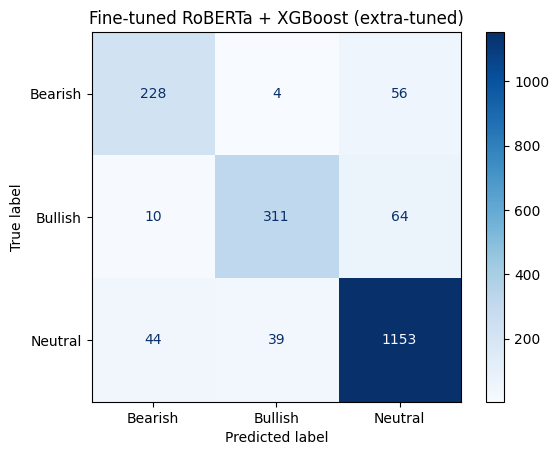

In [ ]:
xgb = XGBClassifier(
    objective="multi:softmax",  # since no need for proba
    num_class=3,
    eval_metric="mlogloss", # metric for classification
    tree_method="hist",
    random_state=SEED,
)

param_dist = {
    "n_estimators": randint(100, 300),
    "learning_rate": loguniform(1e-3, 2e-1),
    "max_depth": randint(2, 8),
    "min_child_weight": randint(1, 10),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3),
}

search = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=20, scoring="f1_macro", cv=cv_extra,
    n_jobs=-1, verbose=1, random_state=SEED
)

search.fit(X_train_emb_finetuned, y_train)
best_xgb = search.best_estimator_

print("Best params:", search.best_params_)
print("CV best score:", search.best_score_)

y_pred = best_xgb.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred, "Fine-tuned RoBERTa + XGBoost (extra-tuned)")
add_to_leaderboard("Fine-tuned RoBERTa + XGBoost (extra-tuned)", y_val, y_pred, leaderboard_final)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CV f1_macro: 0.905909030730774
Best params: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 300}
Fine-tuned RoBERTa + Random Forest (extra-tuned)
Accuracy: 0.8821
Macro-F1 : 0.8519
              precision    recall  f1-score   support

     Bearish      0.796     0.812     0.804       288
     Bullish      0.852     0.823     0.838       385
     Neutral      0.912     0.917     0.914      1236

    accuracy                          0.882      1909
   macro avg      0.853     0.851     0.852      1909
weighted avg      0.882     0.882     0.882      1909



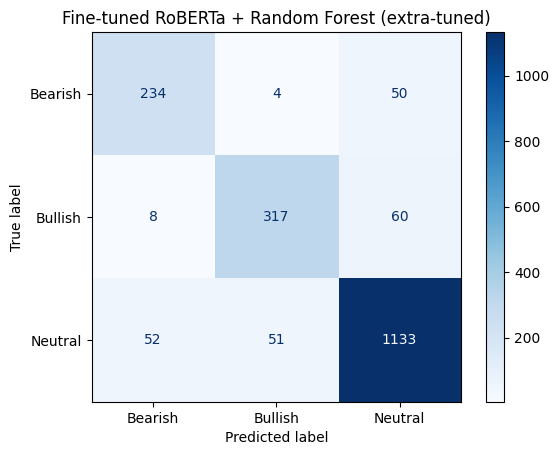

In [ ]:
# Hyper-parameter tuning
rfc = RandomForestClassifier(
    class_weight="balanced",
    random_state=SEED,
    n_jobs=-1
)

param_dist = {
    "n_estimators": [100, 120, 150, 300],
    "max_depth": [None, 2, 5, 10, 20],
    "min_samples_split": randint(2,10),
    "min_samples_leaf": randint(1,9)
}

search = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=param_dist,
    n_iter=20, # since it's too heavy
    scoring='f1_macro',
    cv=cv_extra,
    n_jobs=-1,
    verbose=2,
    random_state=SEED,
    refit=True
)

search.fit(X_train_emb_finetuned, y_train)

best_rfc = search.best_estimator_
print("Best CV f1_macro:", search.best_score_)
print("Best params:", search.best_params_)

y_pred = best_rfc.predict(X_val_emb_finetuned)
evaluate_multiclass(y_val, y_pred, "Fine-tuned RoBERTa + Random Forest (extra-tuned)")
add_to_leaderboard("Fine-tuned RoBERTa + Random Forest (extra-tuned)", y_val, y_pred, leaderboard_final)


In [ ]:
leaderboard_final_df = pd.DataFrame(leaderboard_final).sort_values("f1_macro", ascending=False).reset_index(drop=True)
leaderboard_final_df

,model,accuracy,precision_macro,recall_macro,f1_macro
0,Fine-tuned RoBERTa + LinearSVC (extra-tuned),0.882661,0.847961,0.861504,0.854275
1,Fine-tuned RoBERTa + XGBoost (extra-tuned),0.886328,0.864259,0.844102,0.853590
2,Fine-tuned RoBERTa + Random Forest (extra-tuned),0.882137,0.853191,0.850848,0.851906
3,Fine-tuned RoBERTa + LinearSVC (extra-tuned-sc...,0.878994,0.844180,0.856344,0.849712
